# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
from IPython.display import display, HTML, Math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from heatmap import heatmap48, spotsh, spotsv
import pybroom as br

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['font.size'] = 14

In [3]:
from fretbursts import *

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/fretbursts/__init__.py:63: UserWarning:  - Cannot import QT, custom GUI widgets disabled.
  warnings.warn((' - Cannot import QT, custom GUI widgets disabled.'))


 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [4]:
sns = init_notebook(apionly=True)

In [5]:
plot_timetraces = True

In [6]:
_plot_status = {}

# Load HDF5 files

In [7]:
mlabel = '05_-8TA_-3NTD_500pM_no-flow_vs_10uL-hr_flow'
mlabel
#save_name('name', folder='.')

'05_-8TA_-3NTD_500pM_no-flow_vs_10uL-hr_flow'

In [8]:
dir_ = '.'

In [9]:
# sort to have chronological order for repeats
filepaths = sorted([f for f in Path(dir_).glob('*.hdf5') 
                   if '0-80s' in f.stem and 'cache' not in f.stem]) 
fnames = [f.name for f in filepaths]
fnames

['05_-8TA_-3NTD_500pM_0-80s.hdf5', '06_-8TA_-3NTD_500pM_ASchip_0-80s.hdf5']

In [10]:
f0 = fnames[0][:25]
f1 = fnames[1][:32]
f1

'06_-8TA_-3NTD_500pM_ASchip_0-80s'

# Load data

In [11]:
d0 = loader.photon_hdf5(fnames[0])
d1 = loader.photon_hdf5(fnames[1])

In [12]:
blue = '#0055d4'
navy = '#000080'
green = '#2ca02c'
limegreen = '#32CD32'
red = '#e74c3c'  # '#E41A1C'
maroon = '#800000'
purple = '#9b59b6'
fuschia = '#FF00FF'
cyan = '#00FFFF'
deepskyblue = '#00BFFF'

In [13]:
def plot_alternation_hist_usalex(d0, d1, bins=None, ax=None, ich0=0, ich1=0, #adding a data object to function
                                 hist_style={}, span_style={}):
    """Plot the us-ALEX alternation histogram for the variable `d`.

    This function must be called on us-ALEX data **before** calling
    :func:`fretbursts.loader.alex_apply_period`.
    """
    if ax is None:
        _, ax = plt.subplots()

    if bins is None:
        bins = 100

    D0_ON, A0_ON = d0._D_ON_multich[ich0], d0._A_ON_multich[ich0]
    D1_ON, A1_ON = d1._D_ON_multich[ich1], d1._A_ON_multich[ich1]
    d0_ch, a0_ch = d0._det_donor_accept_multich[ich0]
    d1_ch, a1_ch = d1._det_donor_accept_multich[ich1]
    offset0 = d0.get('offset', 0)
    offset1 = d1.get('offset', 0)
    
    ph0_times_t, det0_t = d0.ph_times_t[ich0][:], d0.det_t[ich0][:]
    ph1_times_t, det1_t = d1.ph_times_t[ich1][:], d1.det_t[ich1][:]
    period0 = d0.alex_period
    period1 = d1.alex_period
    d0_em_t = (det0_t == d0_ch)
    d1_em_t = (det1_t == d1_ch)
    
    hist_style_ = dict(bins=bins, histtype='step', lw=2, alpha=0.9, zorder=4) #zorder=2
    hist_style_.update(hist_style)
    span_style_ = dict(alpha=0.2, zorder=2) #zorder=1 
    span_style_.update(span_style)

    D0_label = 'Donor: %d-%d, no flow' % (D0_ON[0], D0_ON[1])
    D1_label = 'Donor: %d-%d, Streets chip with 10μL flow rate' % (D1_ON[0], D1_ON[1])
    A0_label = 'Accept: %d-%d, no flow' % (A0_ON[0], A0_ON[1])
    A1_label = 'Accept: %d-%d, Streets chip with 10μL flow rate' % (A1_ON[0], A1_ON[1])

    ax.hist((ph0_times_t[d0_em_t] - offset0) % period0, color=green, label=D0_label,
            **hist_style_)
    ax.hist((ph1_times_t[d1_em_t] - offset1) % period1, color=blue, label=D1_label,
            **hist_style_)
    ax.hist((ph0_times_t[~d0_em_t] - offset0) % period0, color=red, label=A0_label,
            **hist_style_)
    ax.hist((ph1_times_t[~d1_em_t] - offset1) % period1, color=purple, label=A1_label,
            **hist_style_)
    
    ax.set_xlabel('Timestamp MODULO Alternation period')

    if D0_ON[0] < D0_ON[1]:
        ax.axvspan(D0_ON[0], D0_ON[1], color=green, **span_style_)
    else:
        ax.axvspan(0, D0_ON[1], color=green, **span_style_)
        ax.axvspan(D0_ON[0], period0, color=green, **span_style_)
        
    if D1_ON[0] < D1_ON[1]:
        ax.axvspan(D1_ON[0], D1_ON[1], color=green, **span_style_)
    else:
        ax.axvspan(0, D1_ON[1], color=green, **span_style_)
        ax.axvspan(D1_ON[0], period1, color=green, **span_style_)

    if A0_ON[0] < A0_ON[1]:
        ax.axvspan(A0_ON[0], A0_ON[1], color=red, **span_style_)
    else:
        ax.axvspan(0, A0_ON[1], color=red, **span_style_)
        ax.axvspan(A0_ON[0], period0, color=red, **span_style_)
    if A1_ON[0] < A1_ON[1]:
        ax.axvspan(A1_ON[0], A1_ON[1], color=red, **span_style_)
    else:
        ax.axvspan(0, A1_ON[1], color=red, **span_style_)
        ax.axvspan(A1_ON[0], period1, color=red, **span_style_)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

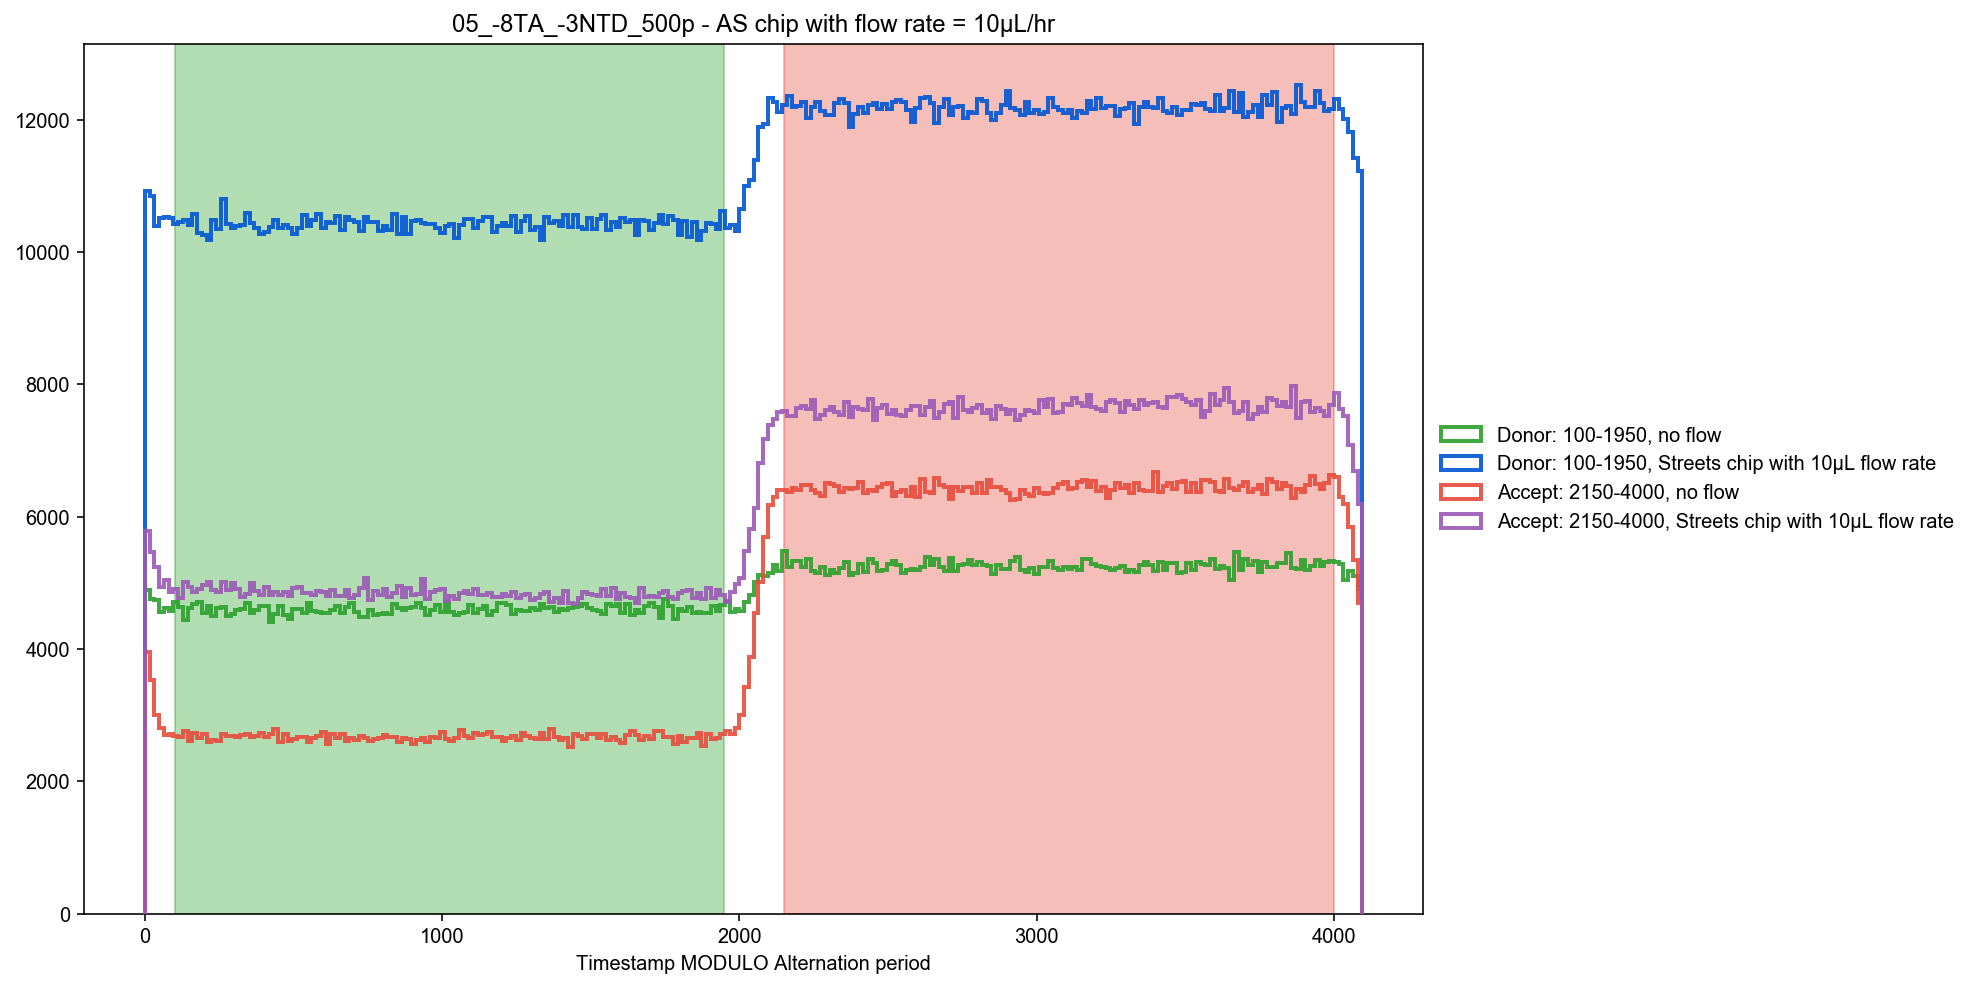

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_alternation_hist_usalex(d0, d1, ax=ax, bins=np.arange(0, 4097, 16))
plt.title(f'{fnames[0][:-12]} - AS chip with flow rate = 10μL/hr');

In [15]:
%%timeit -n1 -r1 
loader.alex_apply_period(d0) 
loader.alex_apply_period(d1)

# Total photons (after ALEX selection):   121,766,143
#  D  photons in D+A excitation periods:   61,895,751
#  A  photons in D+A excitation periods:   59,870,392
# D+A photons in  D  excitation period:    48,825,342
# D+A photons in  A  excitation period:    72,940,801

# Total photons (after ALEX selection):   314,610,922
#  D  photons in D+A excitation periods:  162,968,031
#  A  photons in D+A excitation periods:  151,642,891
# D+A photons in  D  excitation period:    91,730,911
# D+A photons in  A  excitation period:   222,880,011

31.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Select first 0 - 80 s

In [16]:
d0 = d0.slice_ph(time_s1=0, time_s2=80)
d1 = d1.slice_ph(time_s1=0, time_s2=80)

# Timetraces

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

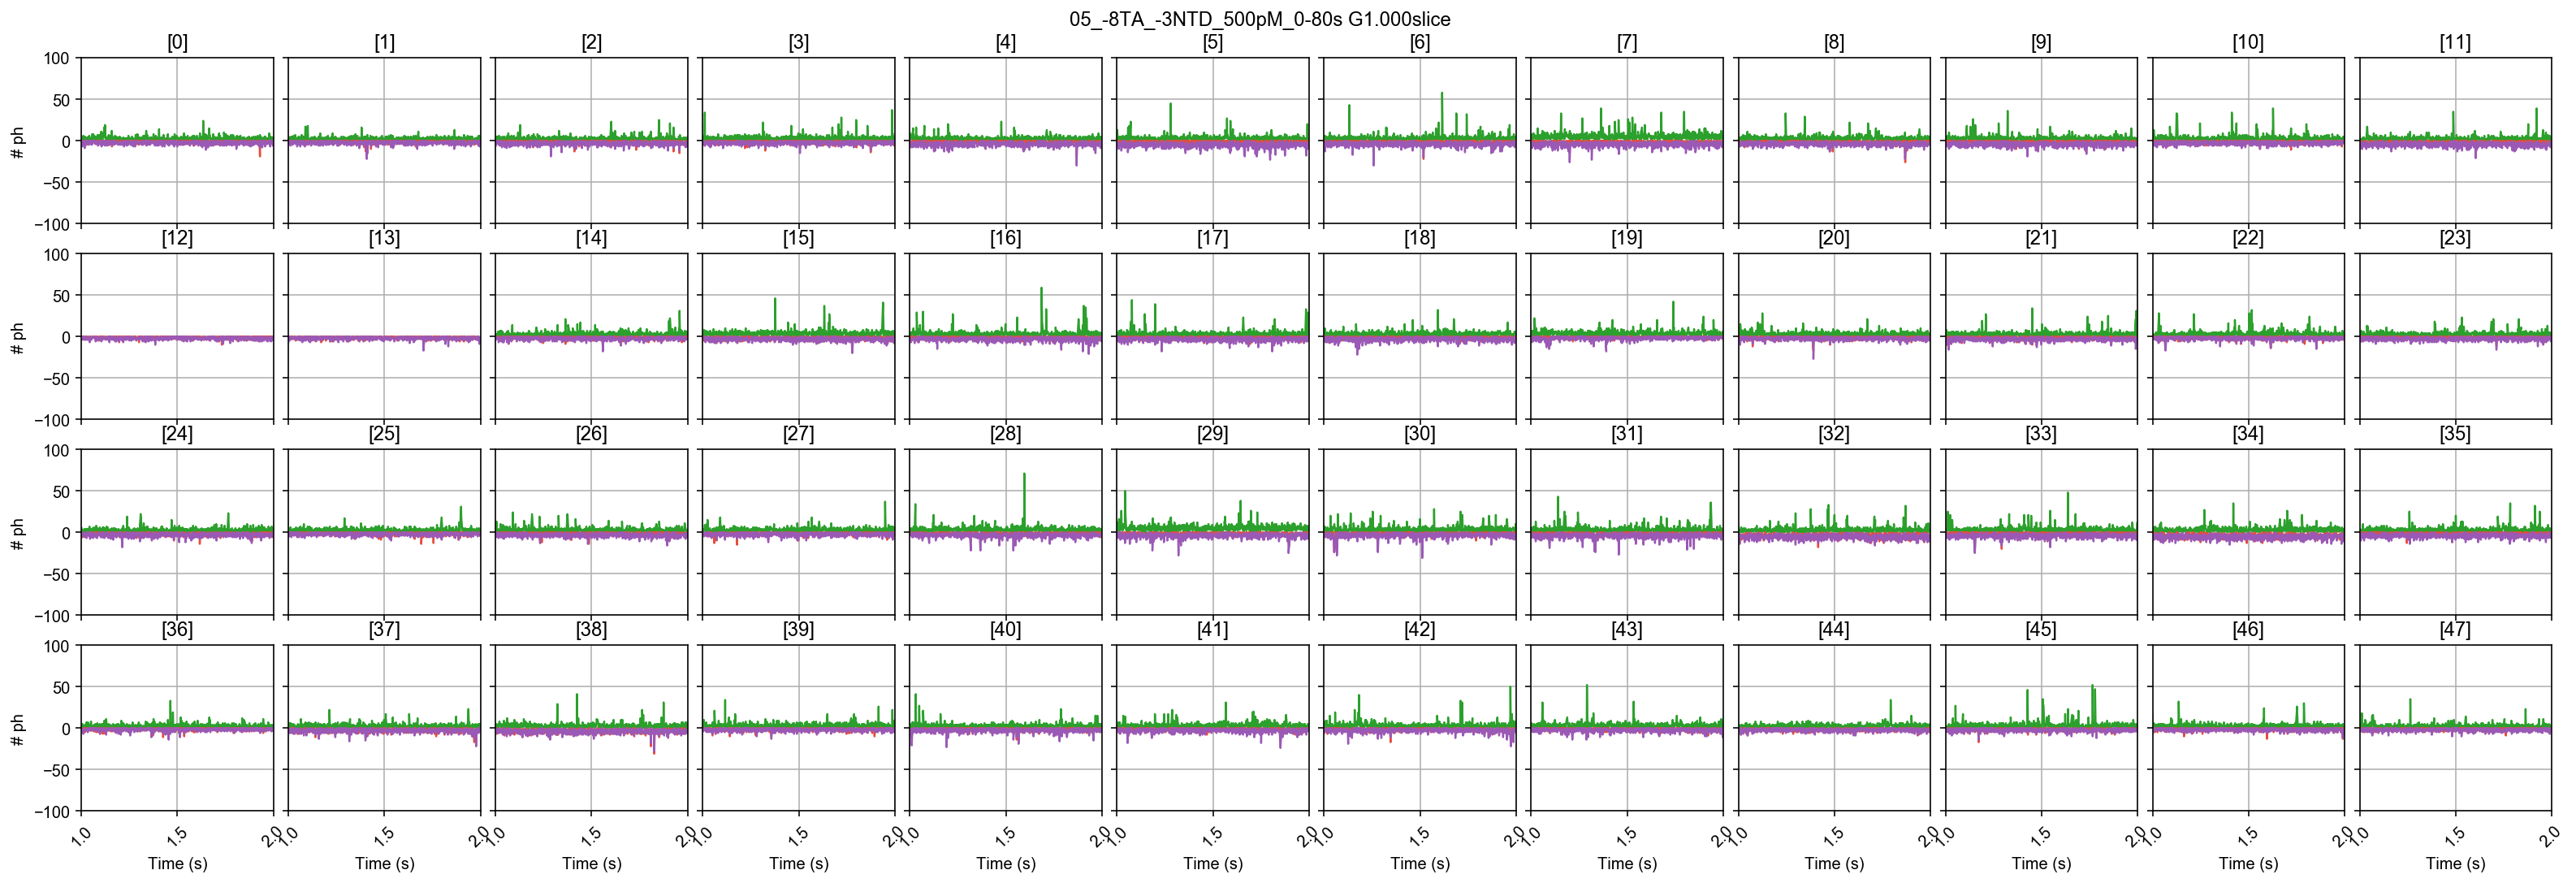

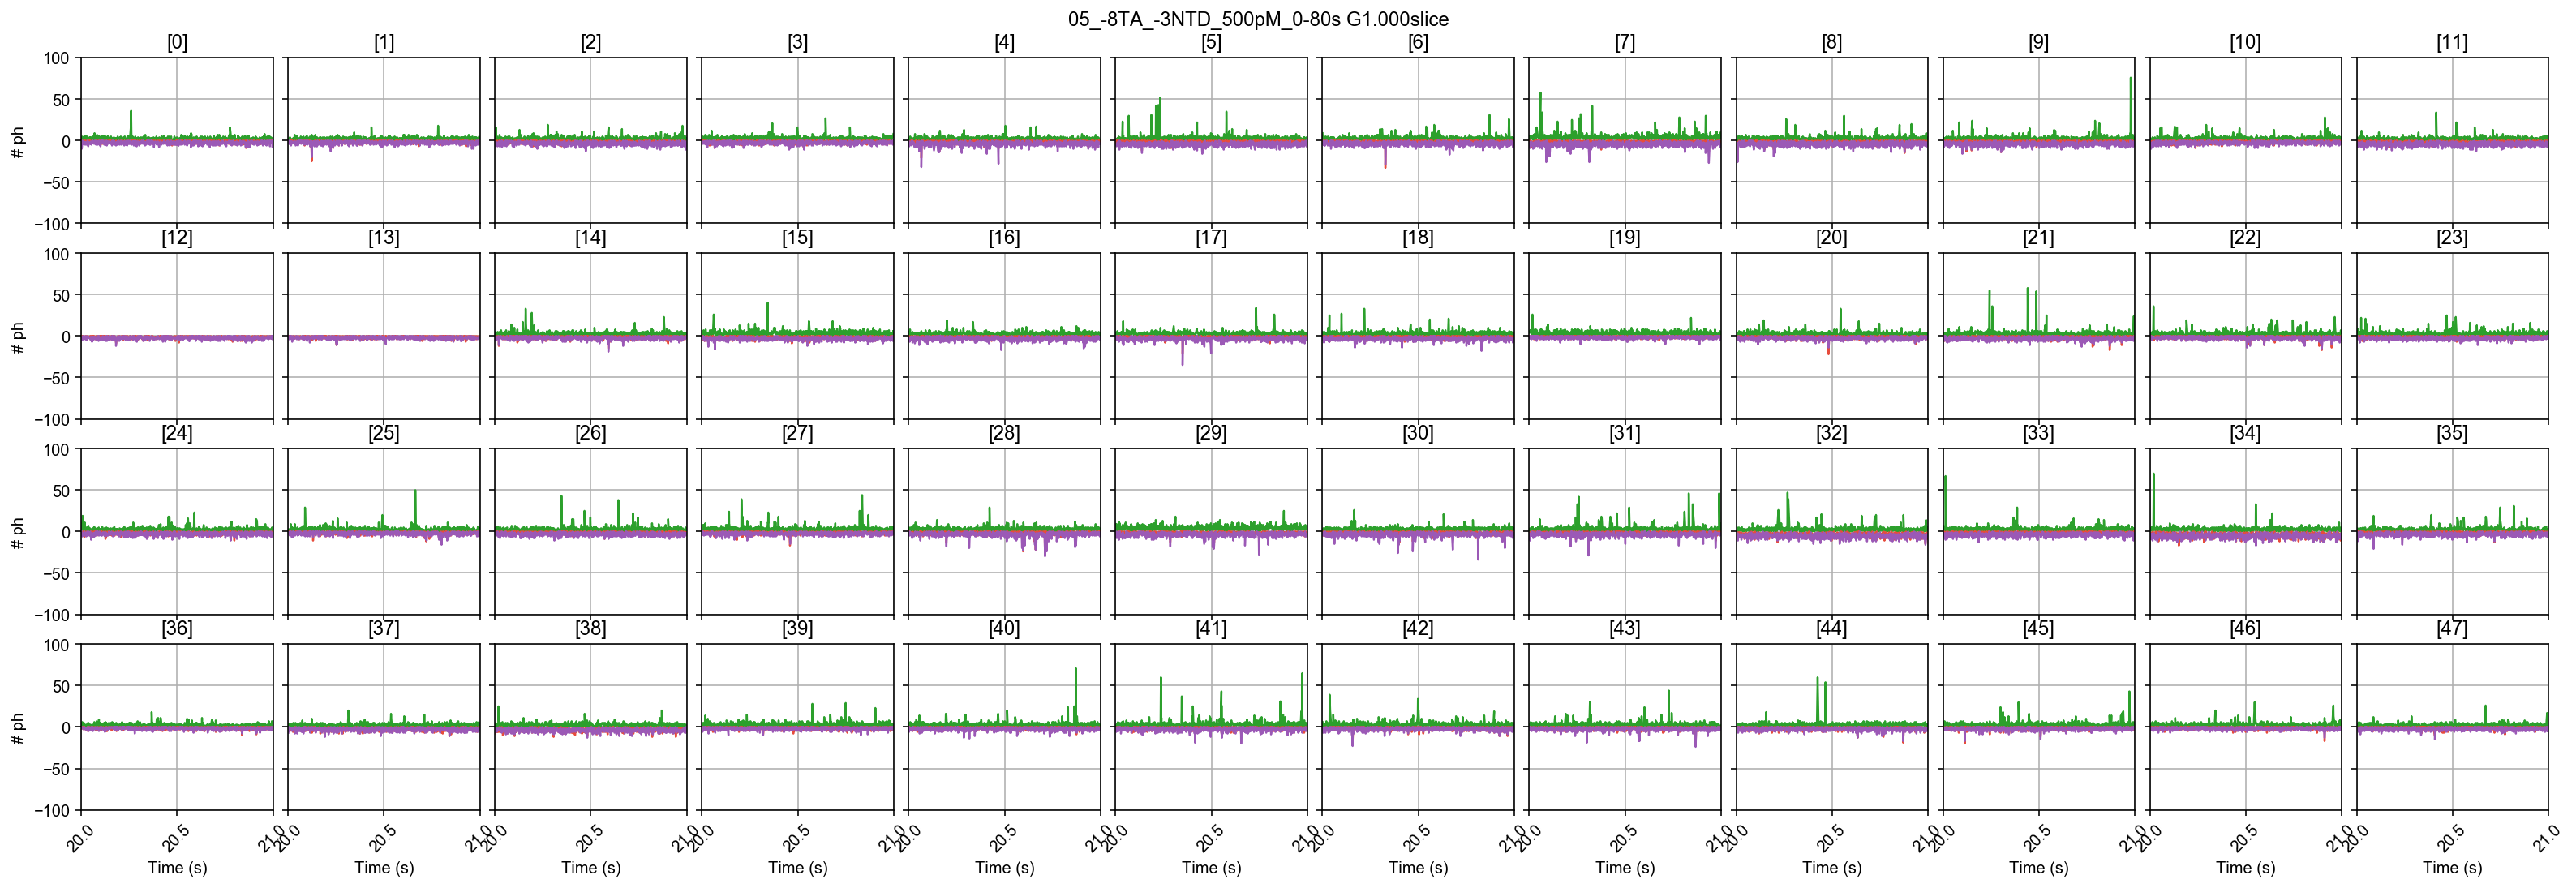

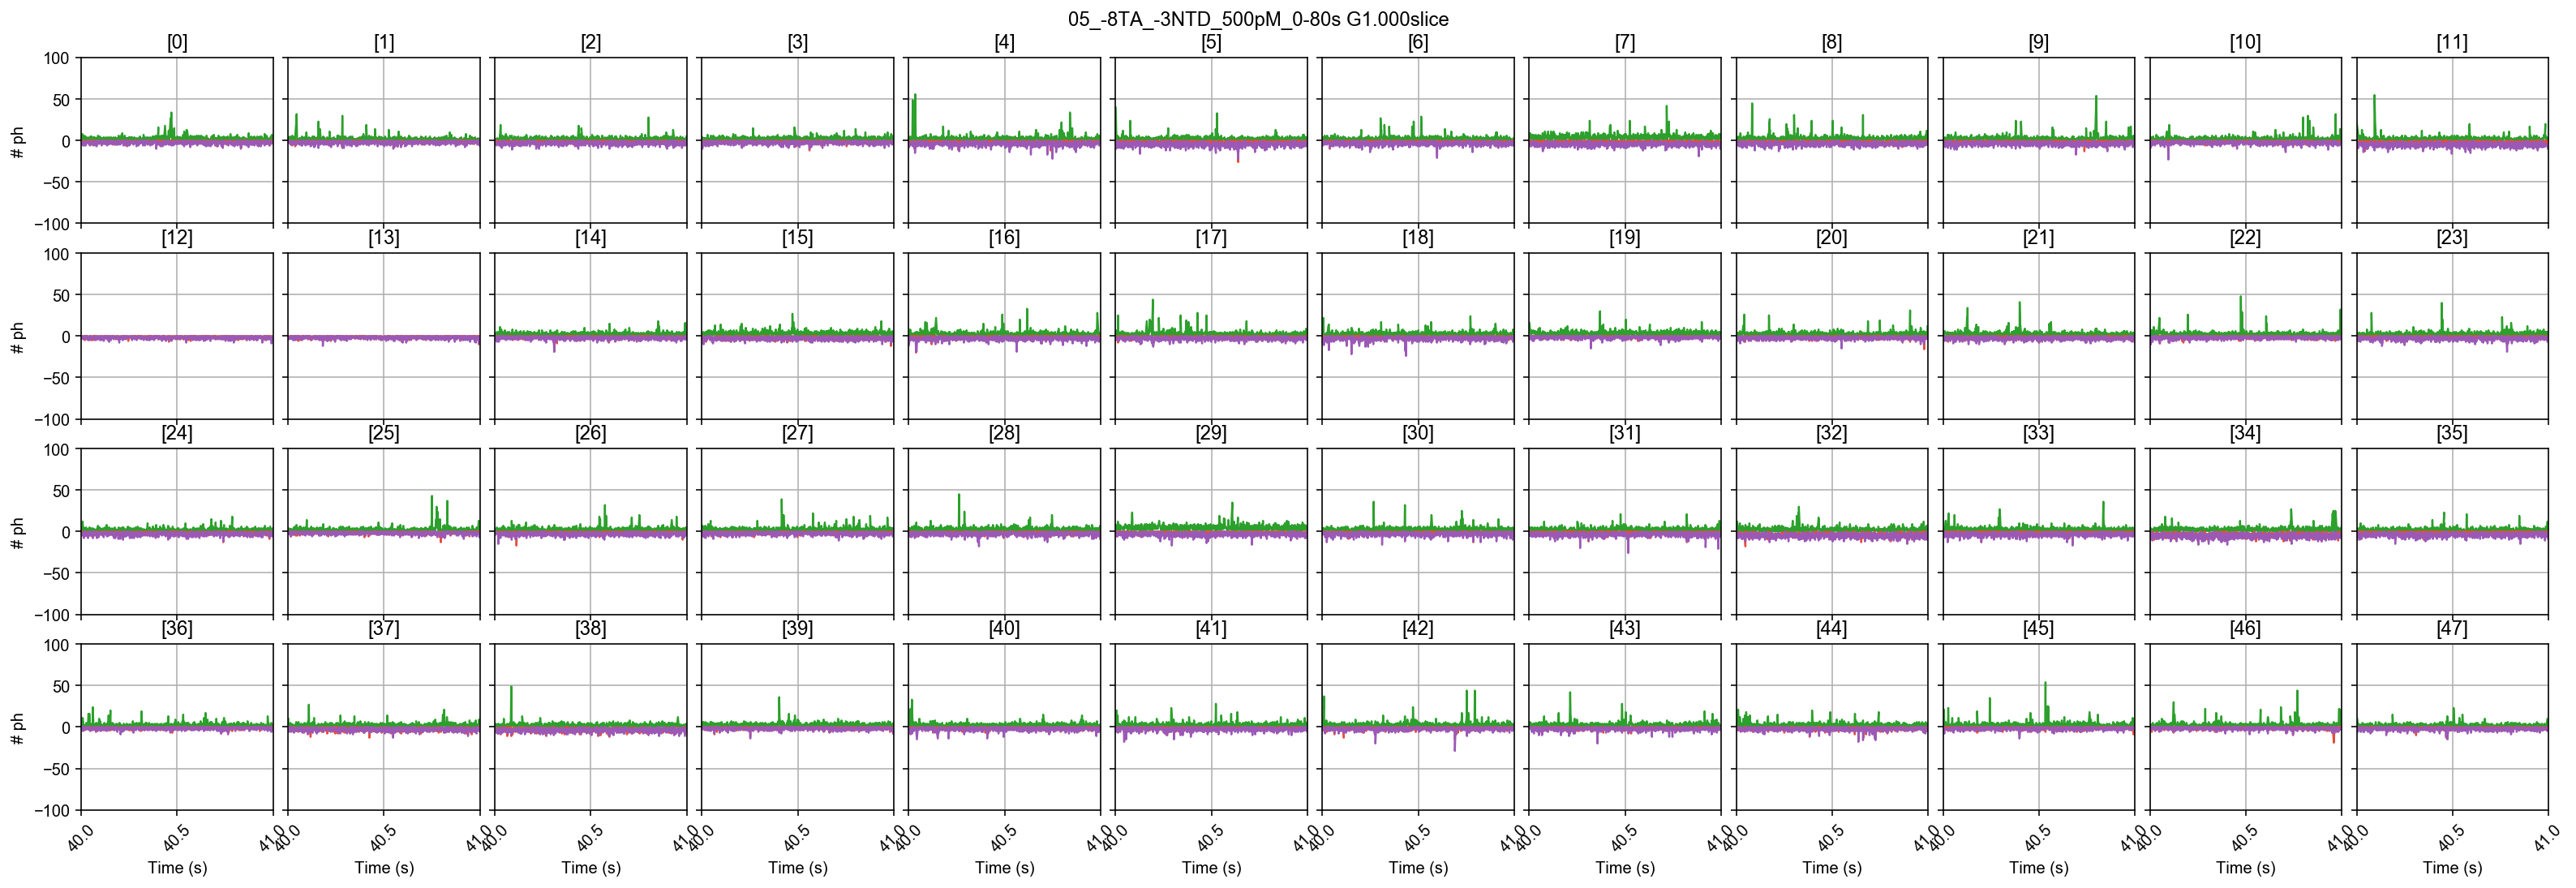

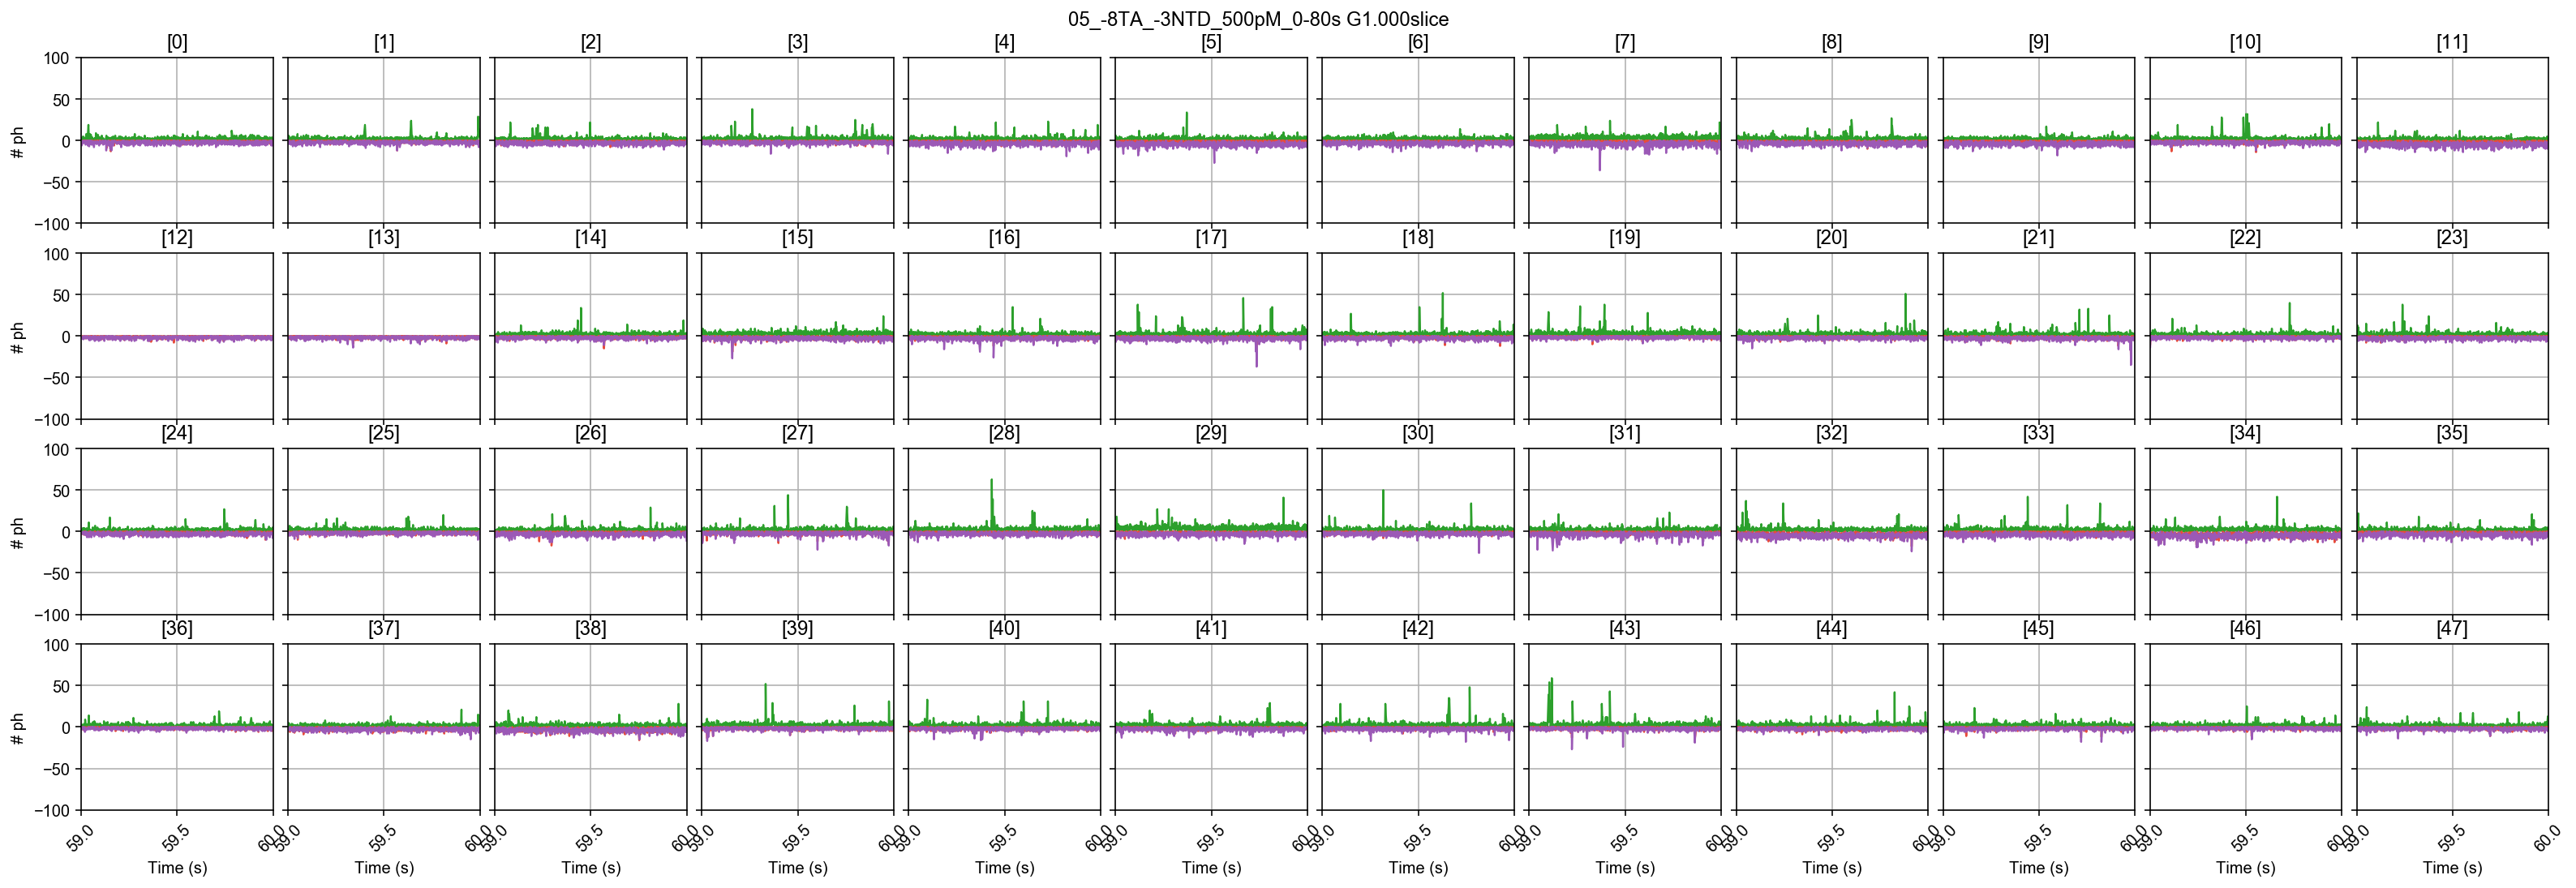

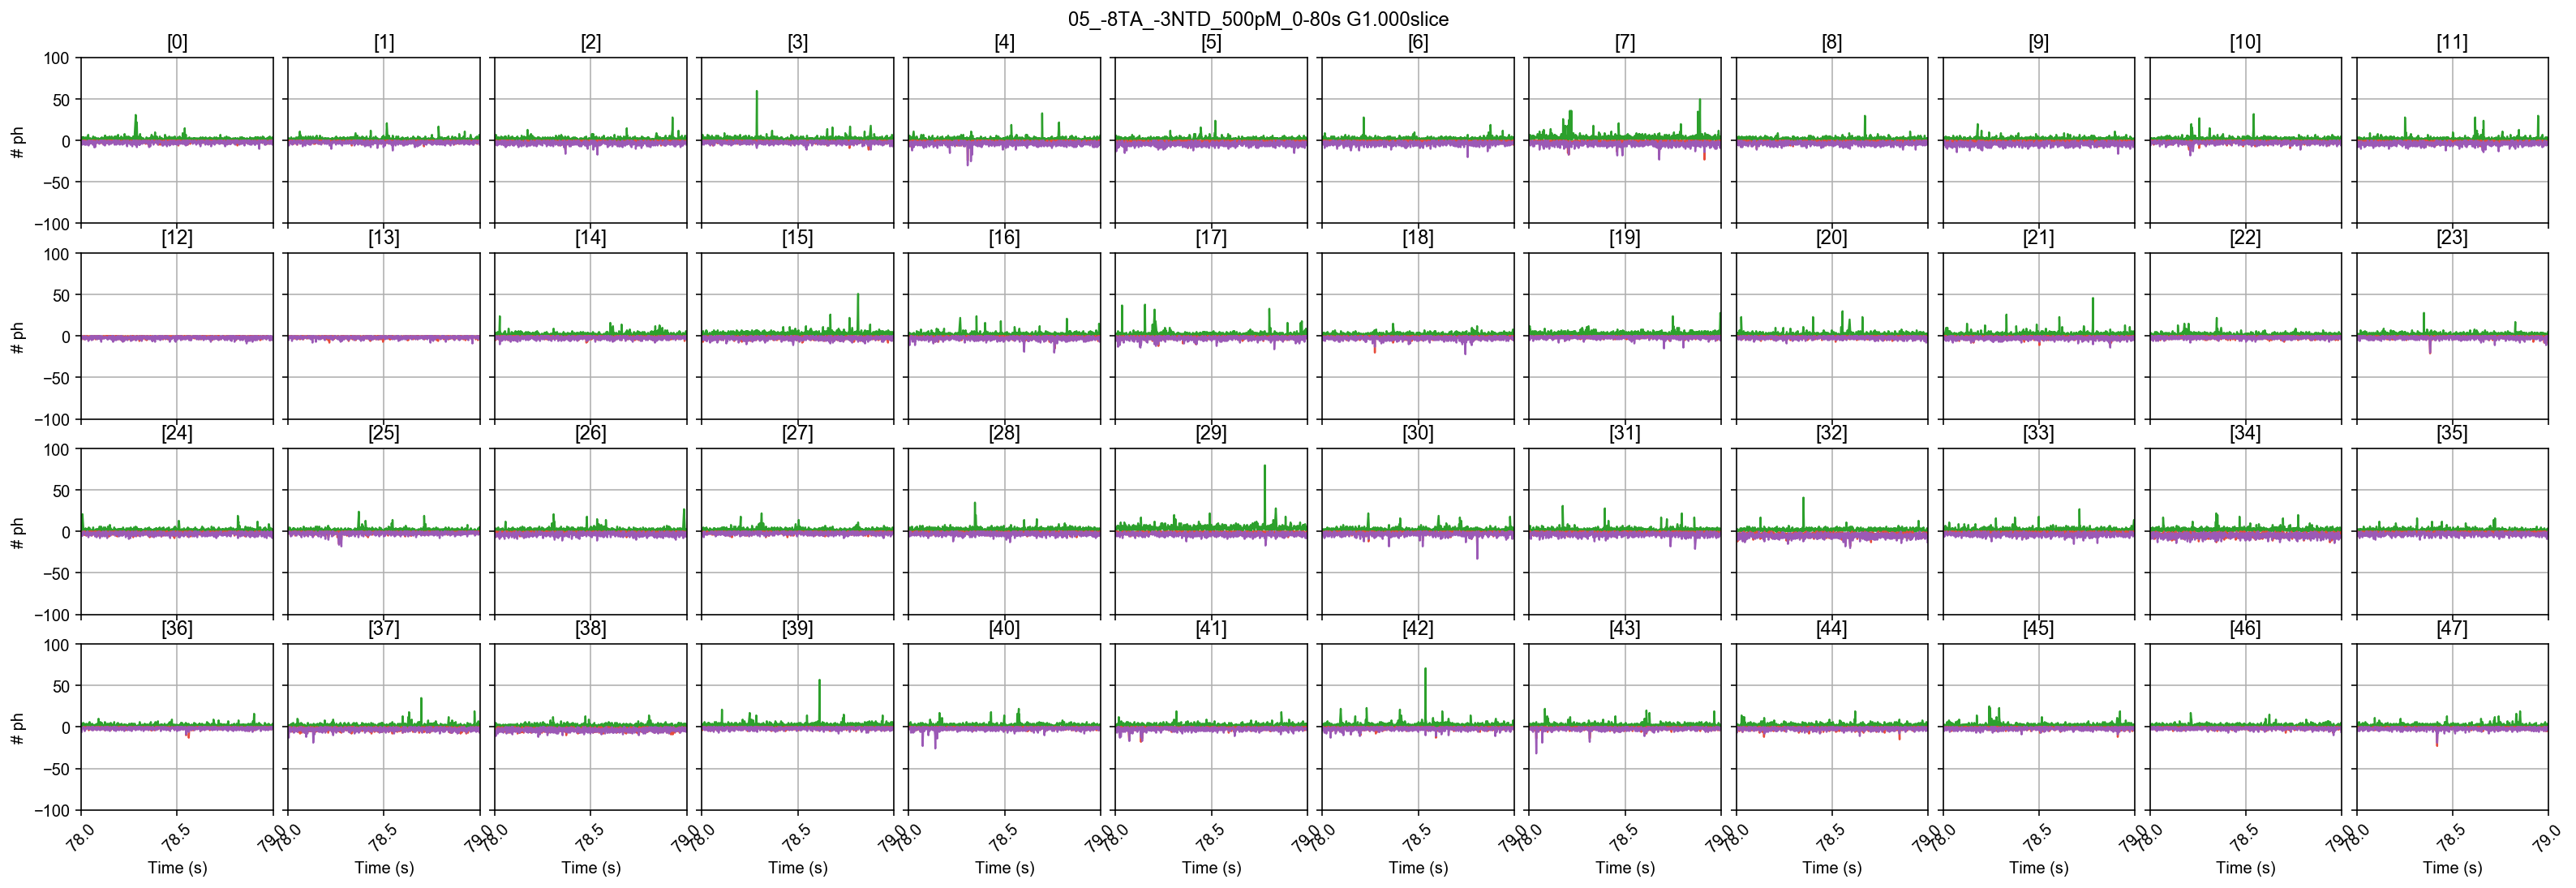

In [17]:
if plot_timetraces:
    num_time_points = 5
    kws = dict(figsize=(24, 8), xrotation=45)
    
    # Timepoints equally distributed along the measurement
    time_points = np.round(np.linspace(d0.time_min+1, d0.time_max-2, num=num_time_points))

    for i in time_points:
        dplot(d0, timetrace, tmin=i, tmax=i+1, **kws);
        plt.ylim(-100, 100)
        #savefig("%s_timetrace_t=%d-%d" % (mlabel[0], i, i+1))

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be rem

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be rem

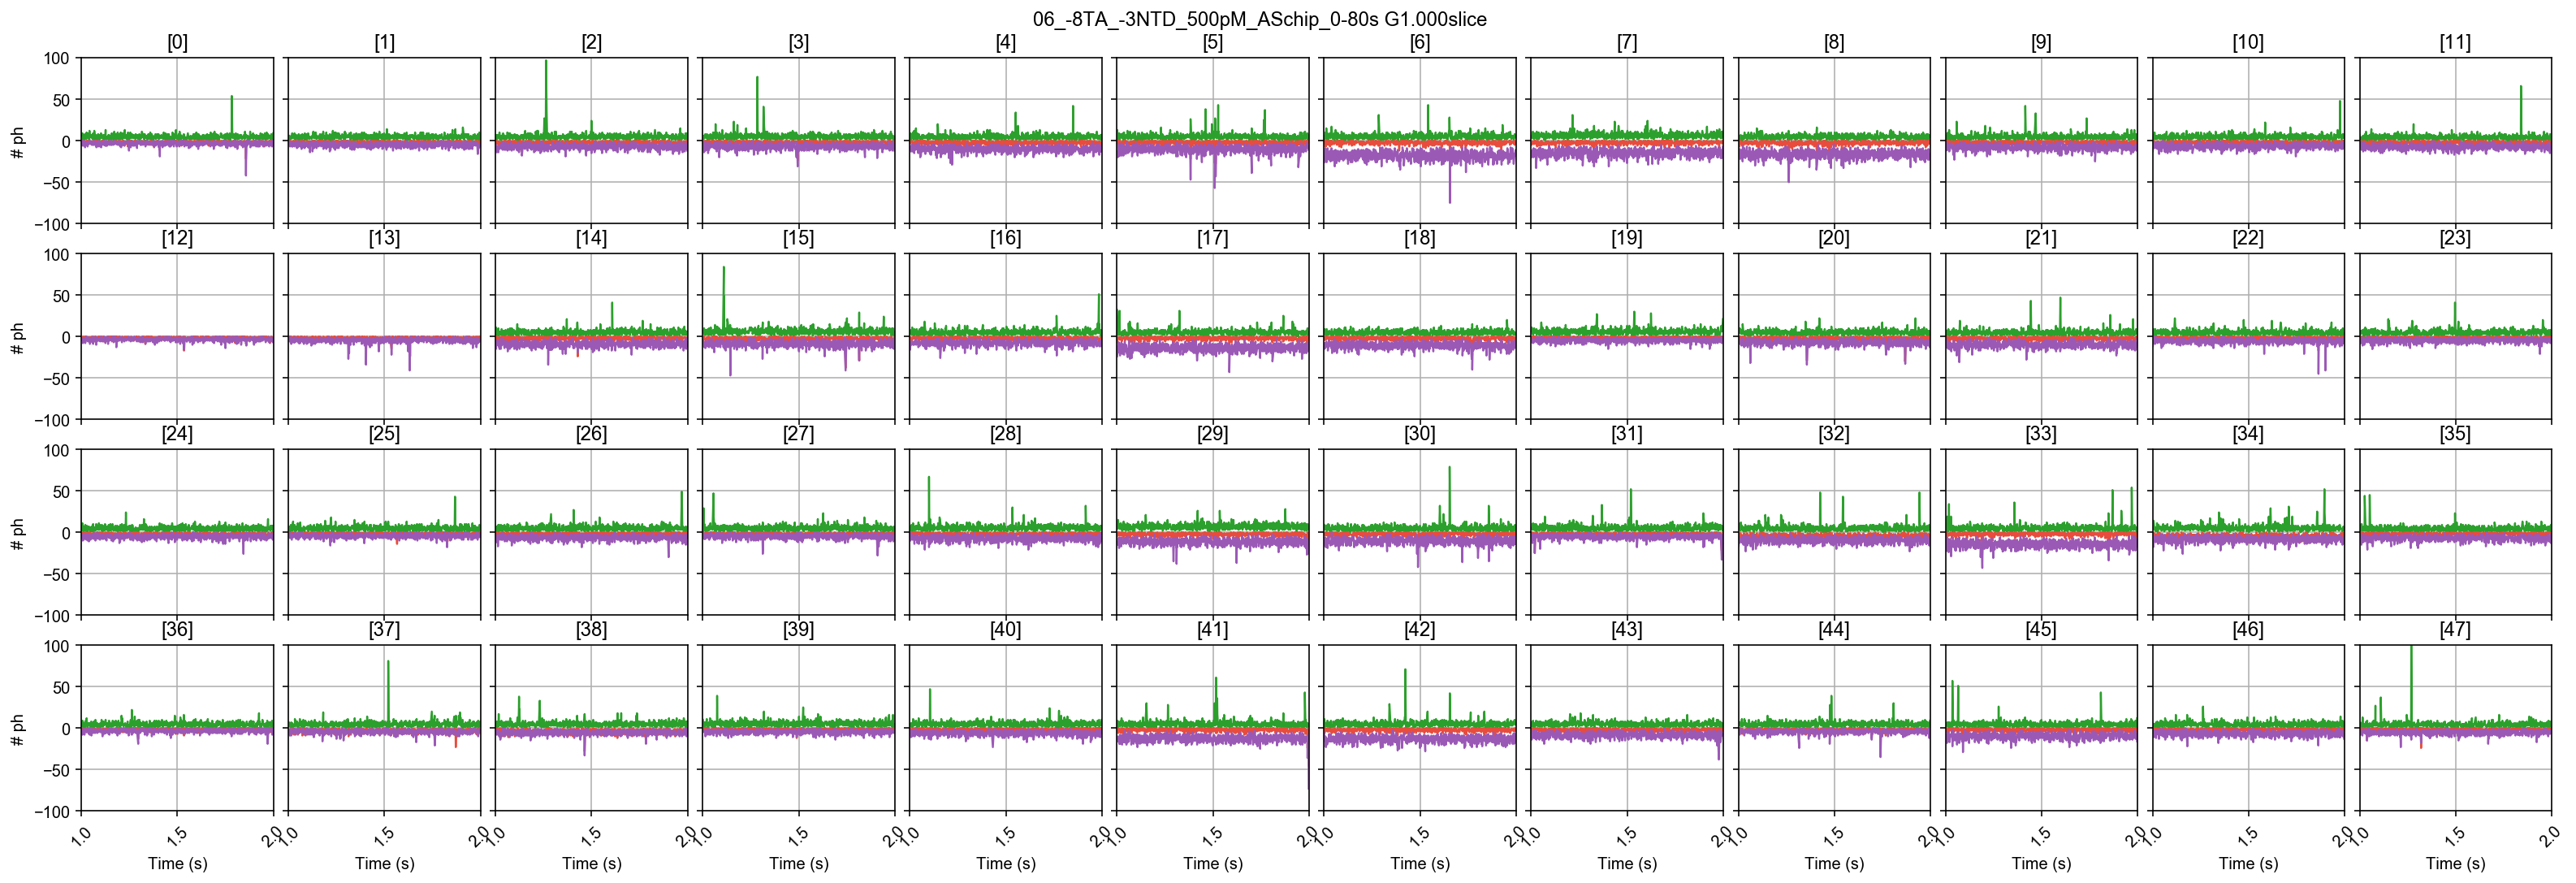

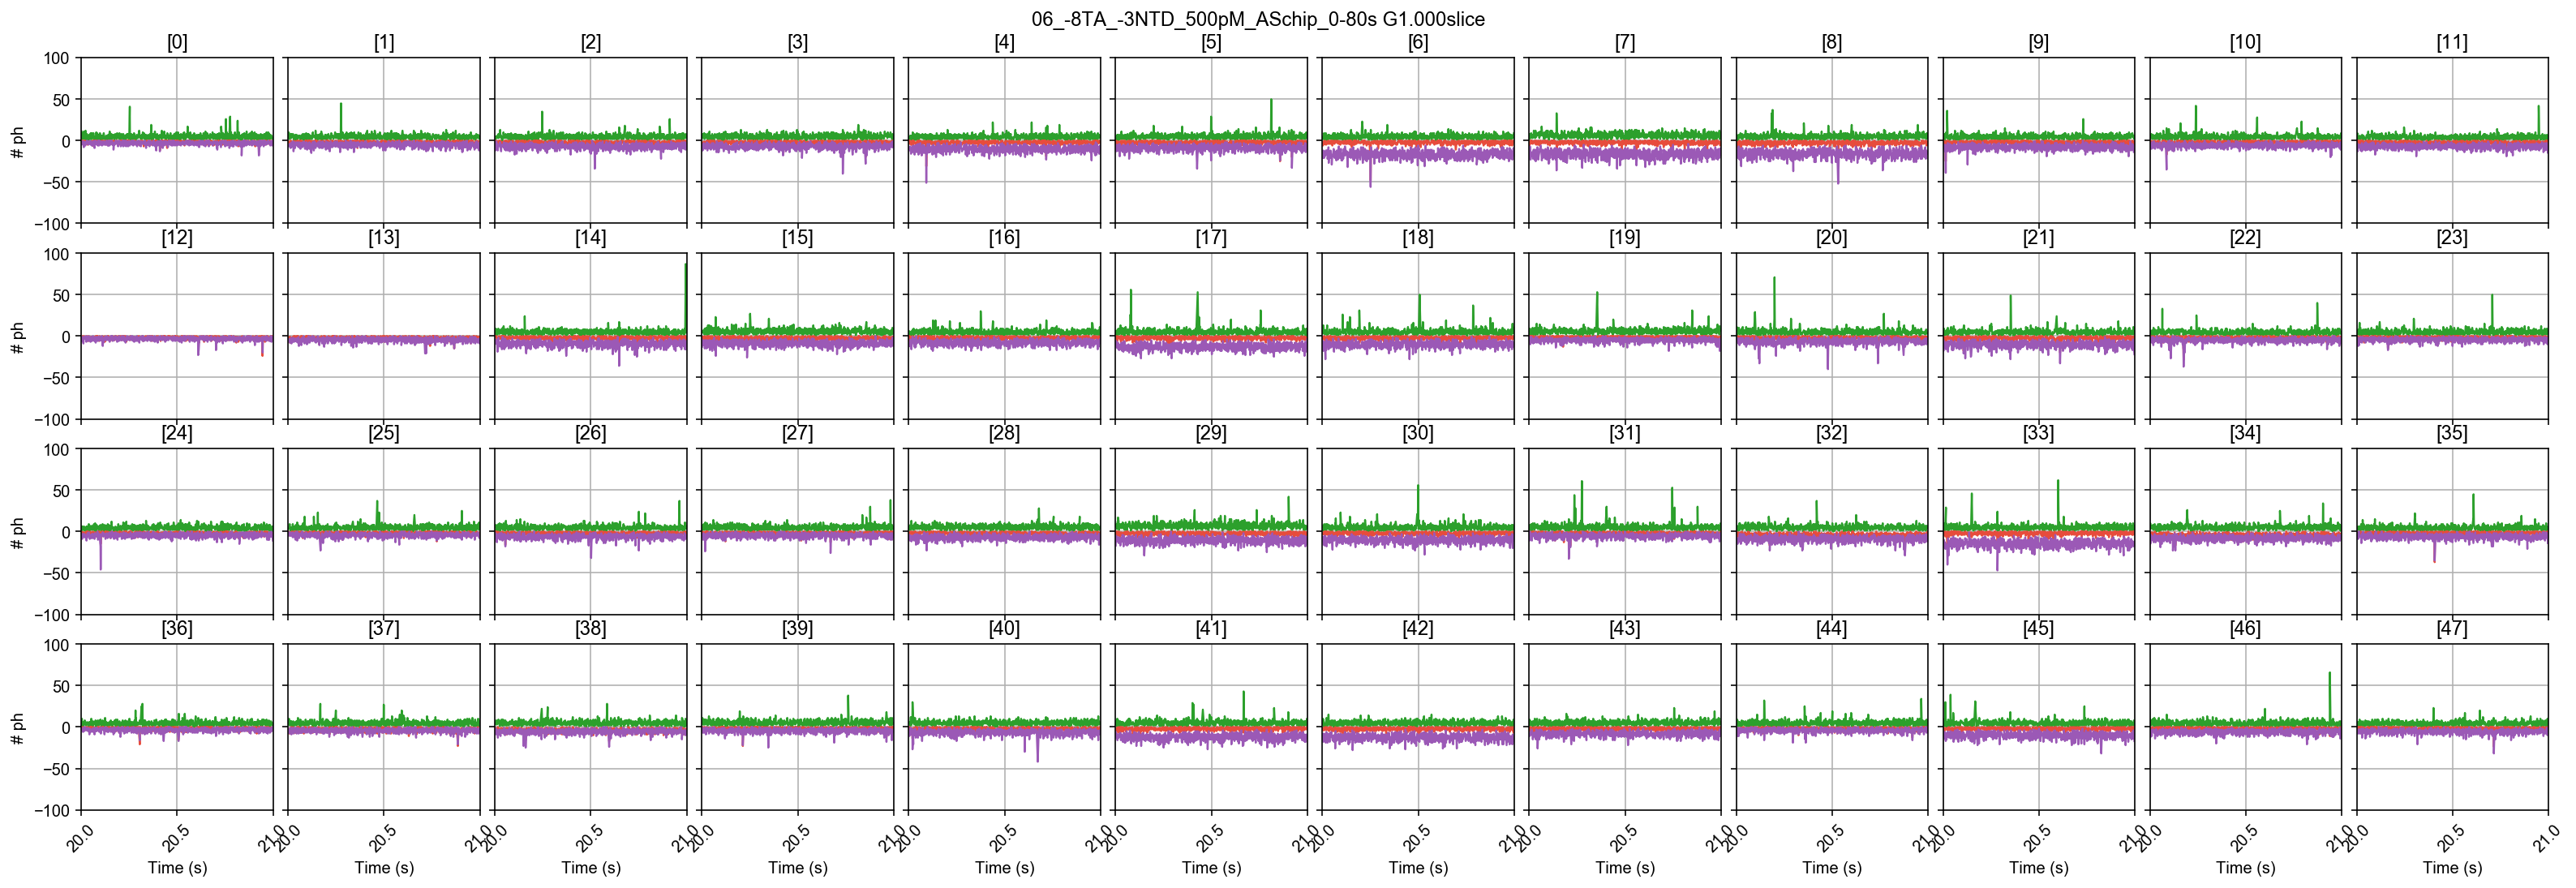

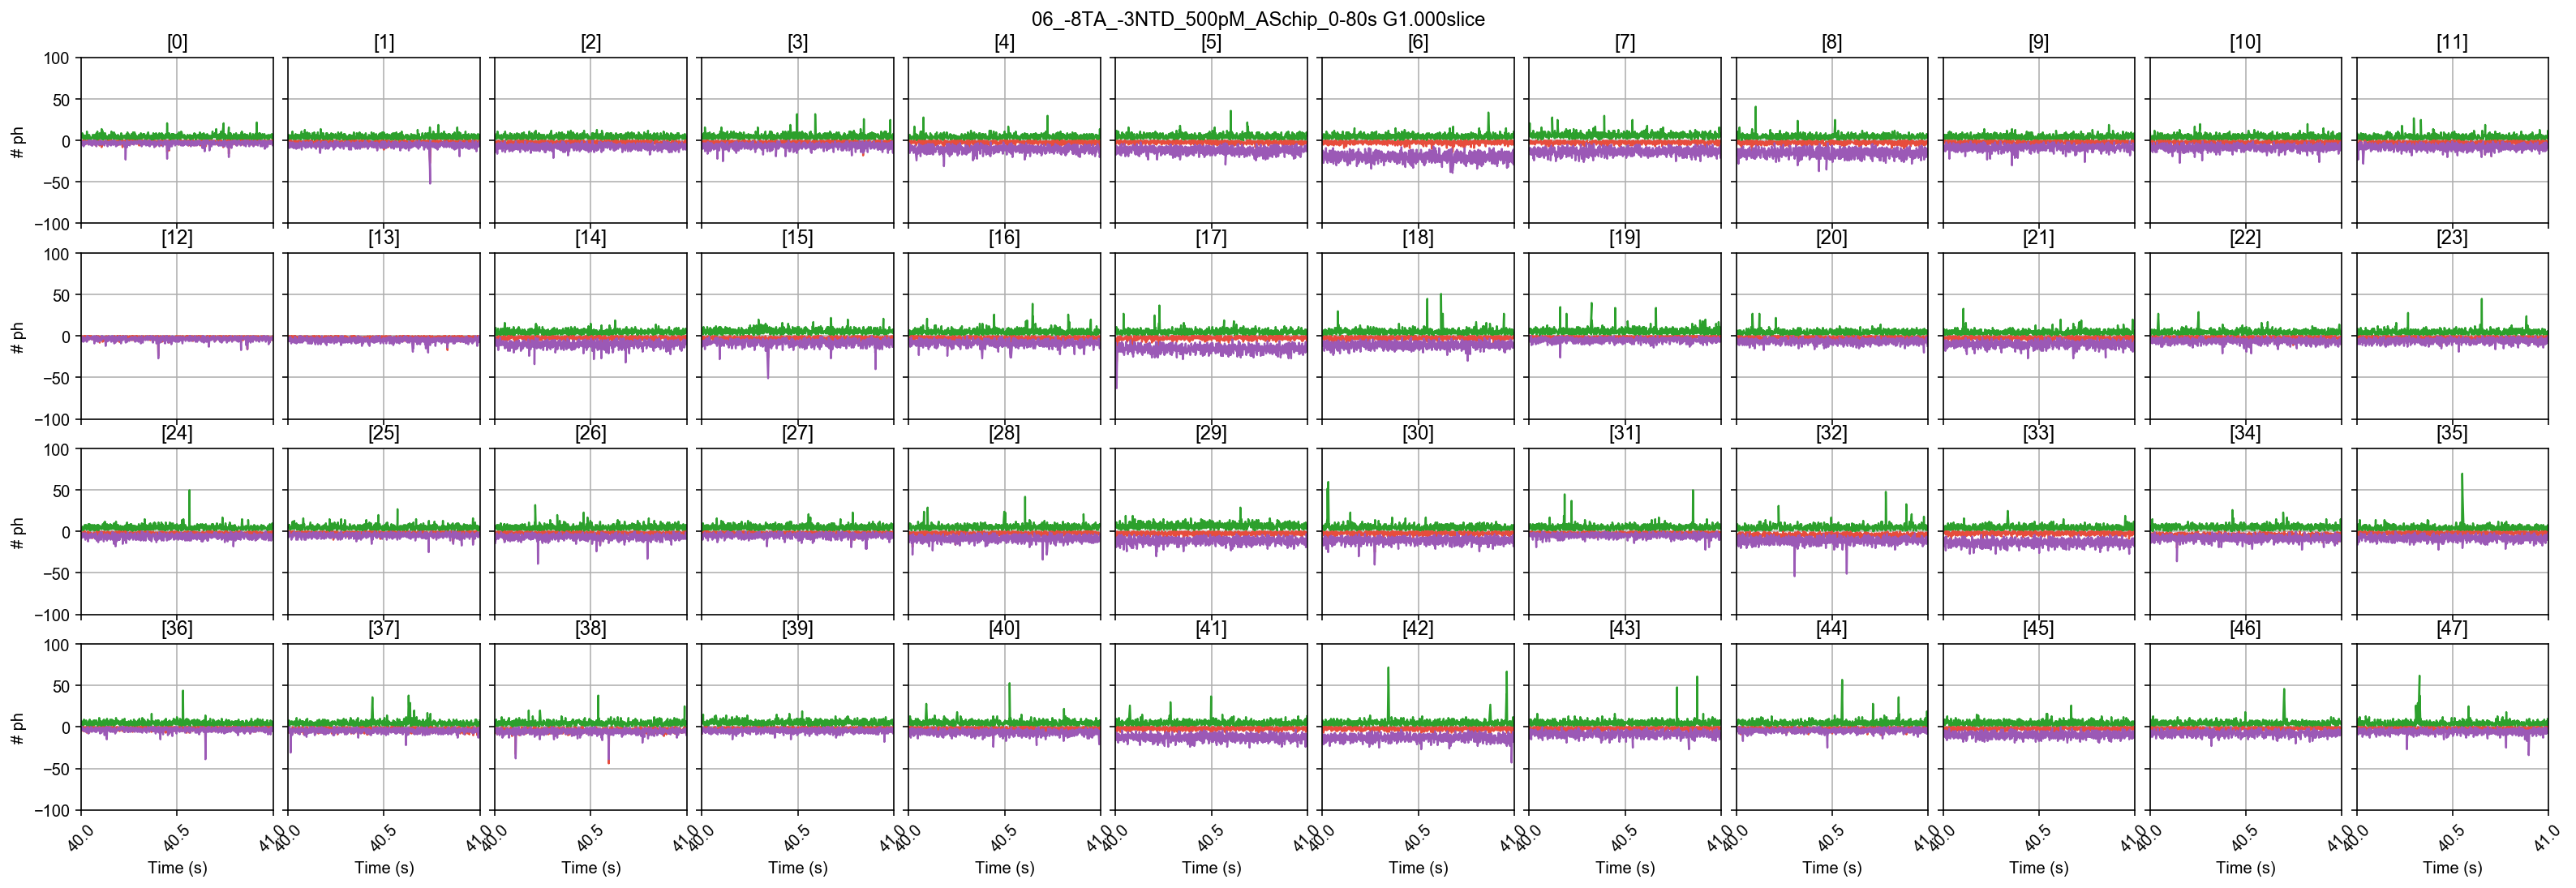

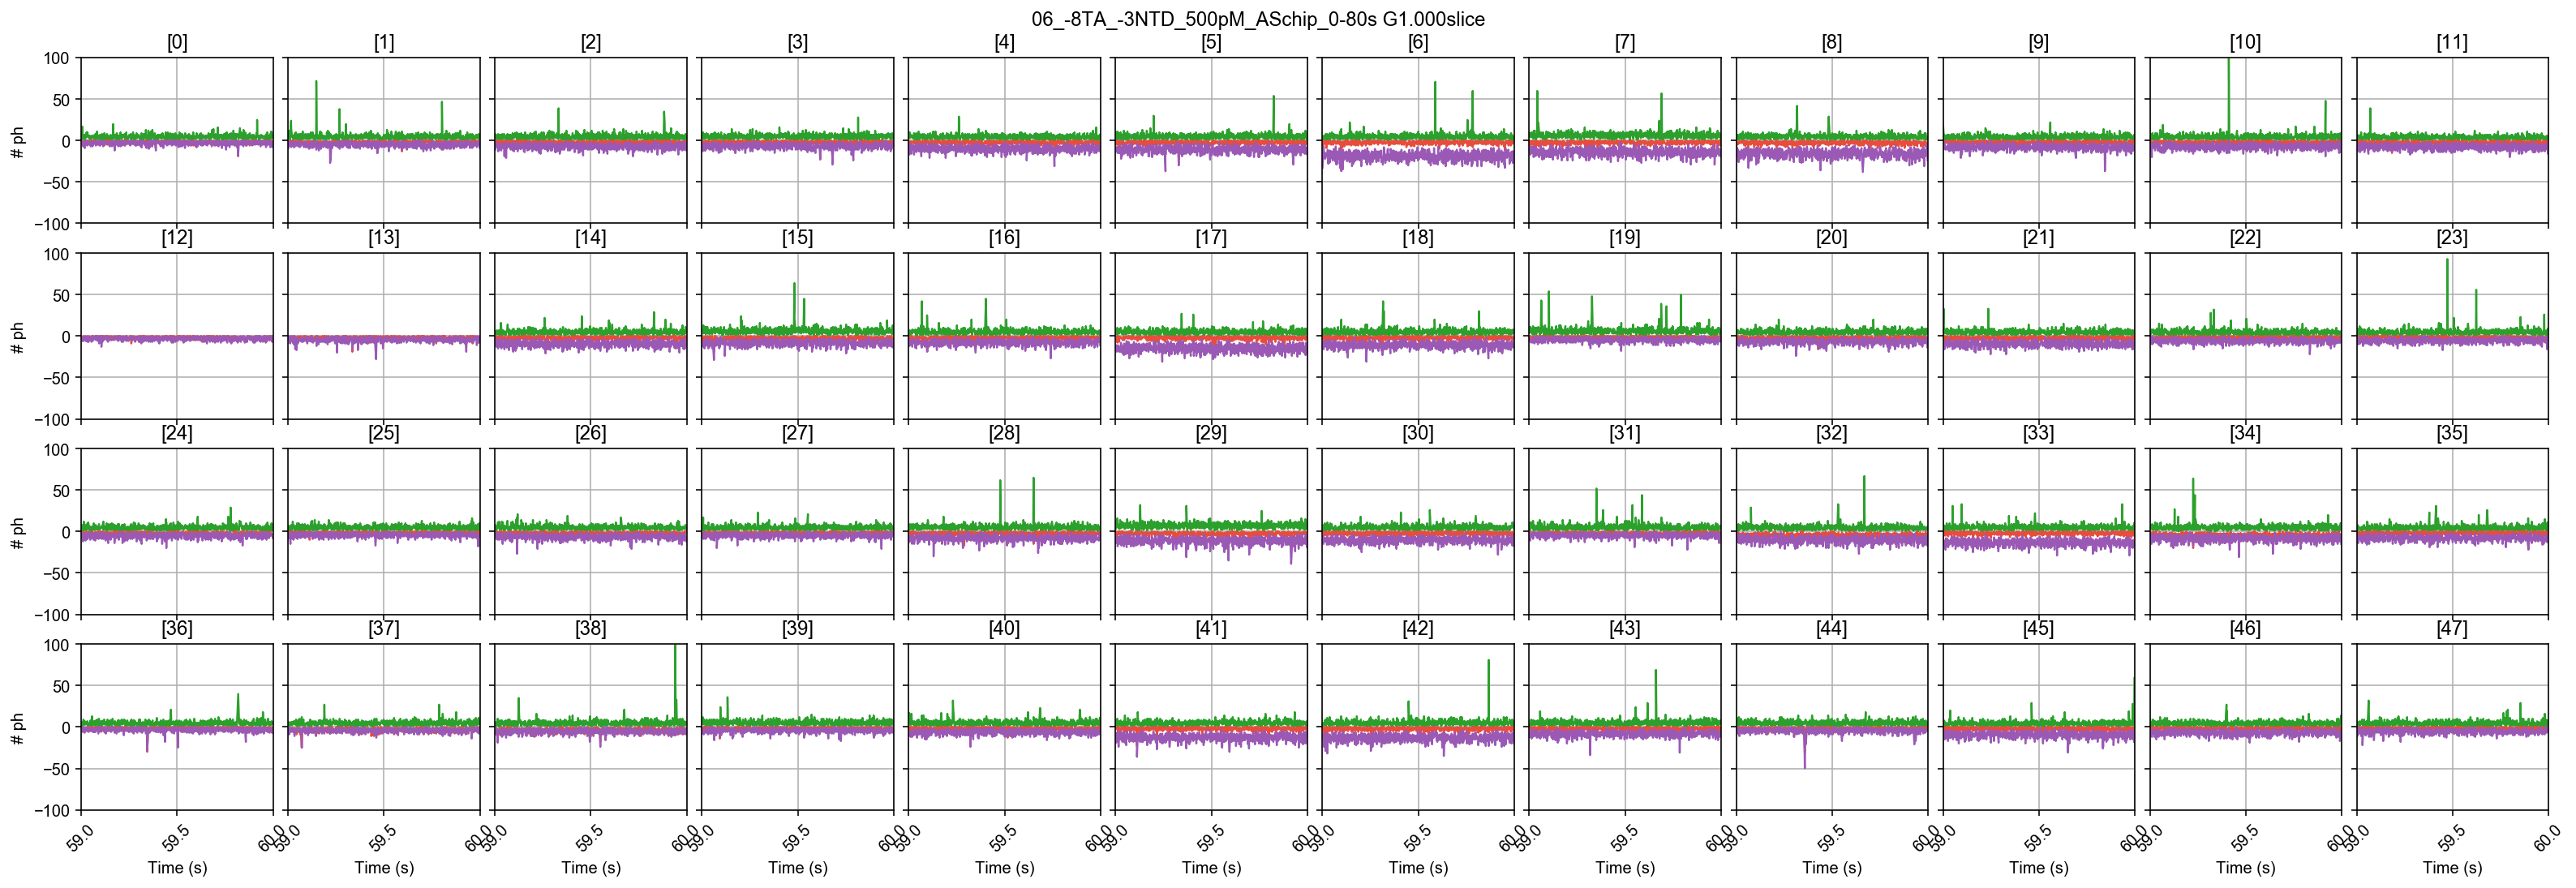

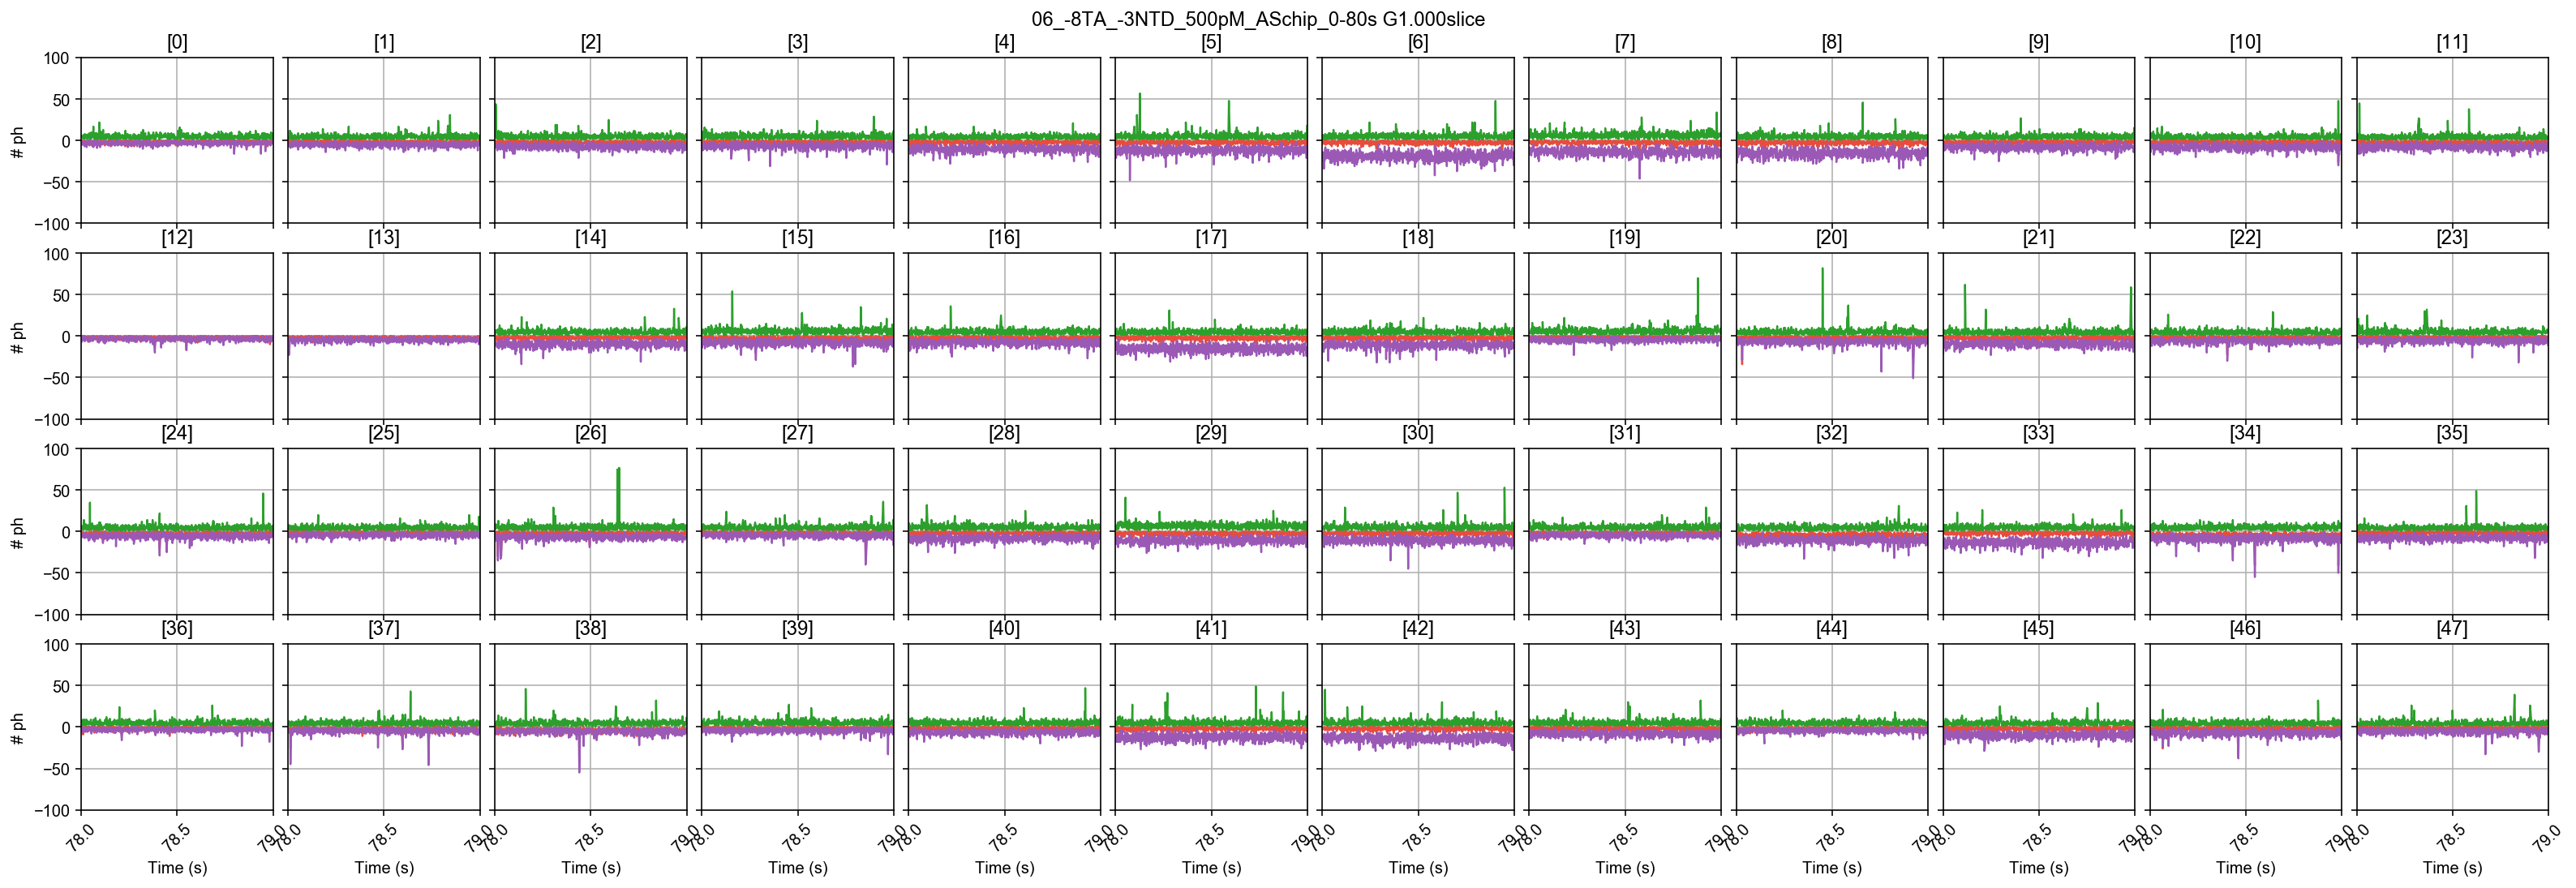

In [18]:
if plot_timetraces:
    num_time_points = 5
    kws = dict(figsize=(24, 8), xrotation=45)
    
    # Timepoints equally distributed along the measurement
    time_points = np.round(np.linspace(d1.time_min+1, d1.time_max-2, num=num_time_points))

    for i in time_points:
        dplot(d1, timetrace, tmin=i, tmax=i+1, **kws);
        plt.ylim(-100, 100)
        #savefig("%s_timetrace_t=%d-%d" % (mlabel[0], i, i+1))

# Background

In [19]:
d0.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)
d1.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=1)

 - Calculating BG rates ... [DONE]
 - Calculating BG rates ... [DONE]


## Plot interphoton delays

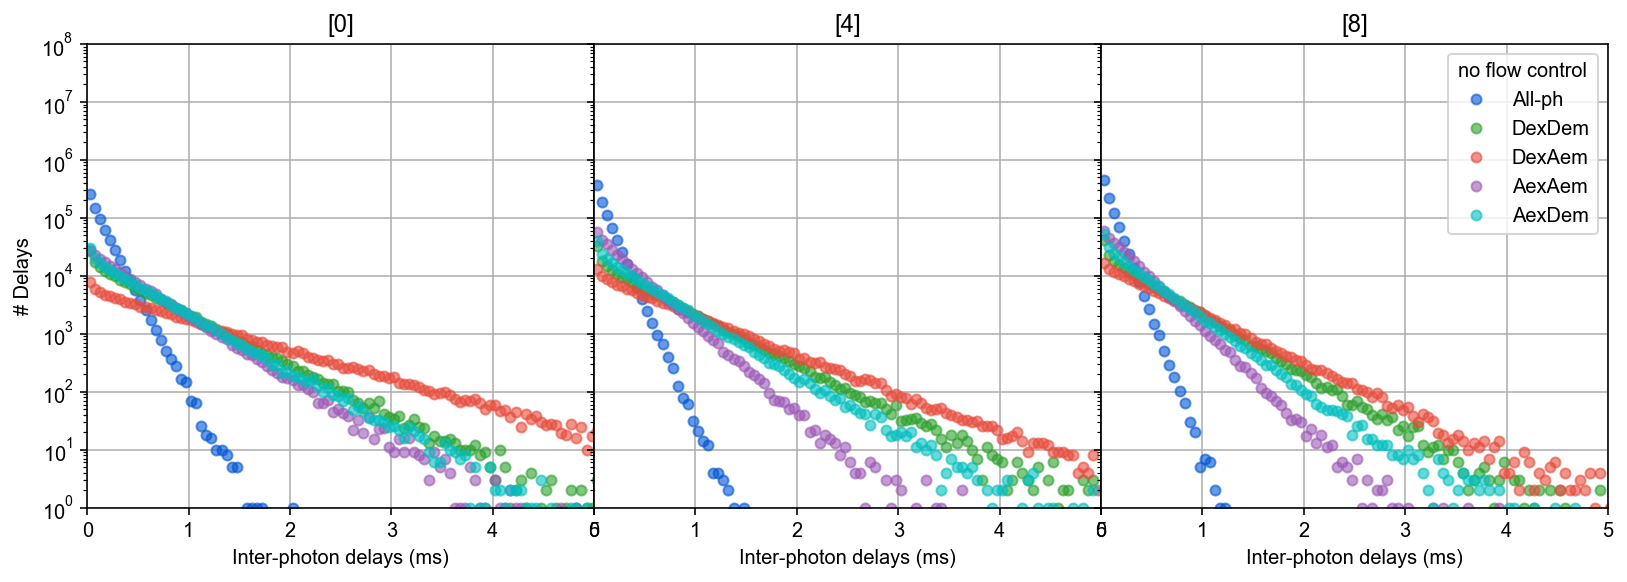

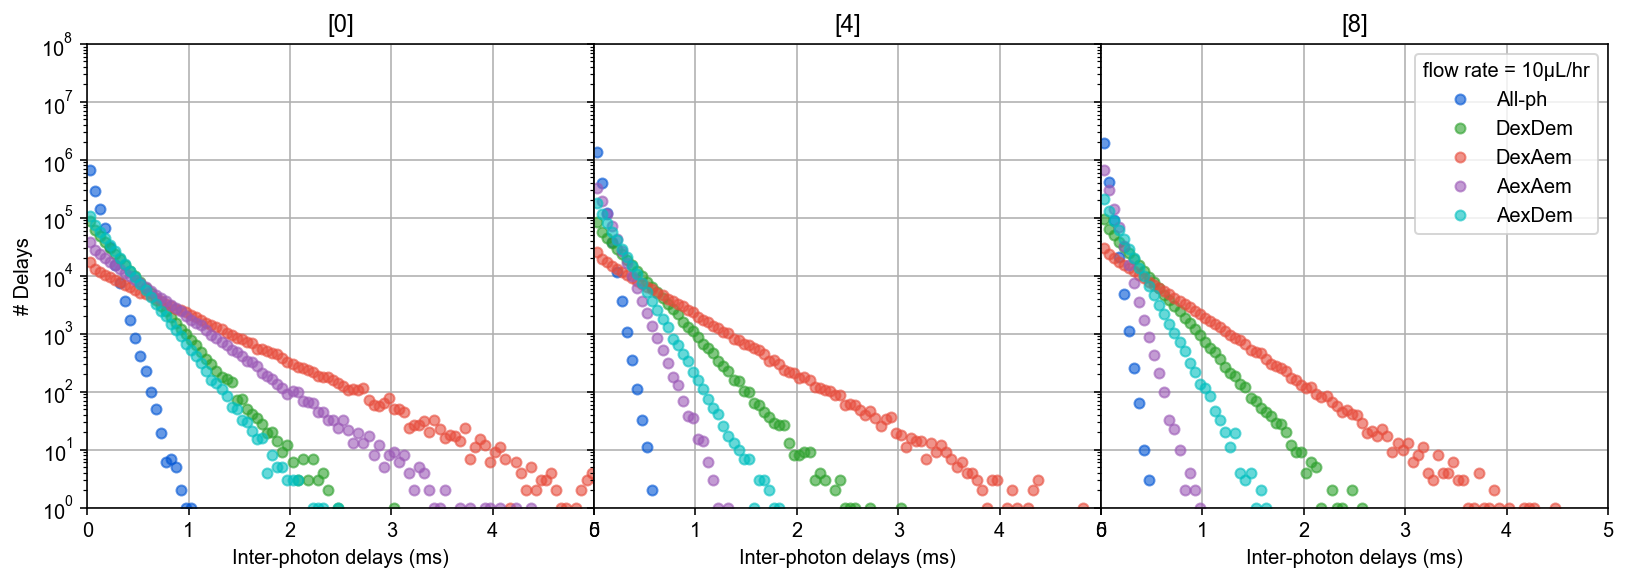

In [20]:
dplot(d0, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(title='no flow control')

dplot(d1, hist_interphoton, binwidth=50e-6, show_da=True, dec=4, 
      suptitle=False, wspace=0, figsize=(12, 4), legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend(title='flow rate = 10μL/hr');

In [21]:
def _normalize_kwargs(kwargs, kind='patch'):
    """Convert matplotlib keywords from short to long form."""
    if kwargs is None:
        return {}

    if kind == 'line2d':
        long_names = dict(c='color', ls='linestyle', lw='linewidth',
                          mec='markeredgecolor', mew='markeredgewidth',
                          mfc='markerfacecolor', ms='markersize',)
    elif kind == 'patch':
        long_names = dict(c='color', ls='linestyle', lw='linewidth',
                          ec='edgecolor', fc='facecolor',)
    for short_name in long_names:
        if short_name in kwargs:
            kwargs[long_names[short_name]] = kwargs.pop(short_name)
    return kwargs

def bsavefig(d, s):
    """Save current figure with name in `d`, appending the string `s`."""
    plt.savefig(d.Name() + s)

In [22]:
_ph_sel_color_dict = {Ph_sel('all'): blue, 
                      Ph_sel(Dex='Dem'): green,
                      Ph_sel(Dex='Aem'): red, 
                      Ph_sel(Aex='Aem'): purple,
                      Ph_sel(Aex='Dem'): 'c', }
_ph_sel_label_dict = {Ph_sel('all'): 'All-ph', 
                      Ph_sel(Dex='Dem'): 'DexDem',
                      Ph_sel(Dex='Aem'): 'DexAem', 
                      Ph_sel(Aex='Aem'): 'AexAem',
                      Ph_sel(Aex='Dem'): 'AexDem'}

In [23]:
def hist_interphoton_single(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None,
                            ph_sel=Ph_sel('all'), period=None,
                            yscale='log', xscale='linear', xunit='ms',
                            plot_style=None):
    
    unit_dict = {'s': 1, 'ms': 1e3, 'us': 1e6, 'ns': 1e9}
    assert xunit in unit_dict
    scalex = unit_dict[xunit]

    # Compute interphoton delays
    if period is None:
        ph0_times = d0.get_ph_times(ich=i, ph_sel=ph_sel)
        ph1_times = d1.get_ph_times(ich=i, ph_sel=ph_sel)
    else:
        ph0_times = d0.get_ph_times_period(ich=i, period=period, ph_sel=ph_sel)
        ph1_times = d1.get_ph_times_period(ich=i, period=period, ph_sel=ph_sel)
    delta_ph0_t = np.diff(ph0_times) * d0.clk_p
    delta_ph1_t = np.diff(ph1_times) * d1.clk_p
    if tmax is None:
        tmax0 = delta_ph0_t.max()
        tmax1 = delta_ph1_t.max()
        
    # Compute bin edges if not passed in
    if bins is None:
        # Shift by half clk_p to avoid "beatings" in the distribution
        # due to floating point inaccuracies.
        bins0 = np.arange(0, tmax0 + binwidth, binwidth) - 0.5 * d0.clk_p
        bins1 = np.arange(0, tmax1 + binwidth, binwidth) - 0.5 * d1.clk_p
    else:
        warnings.warn('Using `bins` and ignoring `tmax` and `binwidth`.')
    t0_ax = bins0[:-1] + 0.5 * binwidth
    t1_ax = bins1[:-1] + 0.5 * binwidth

    # Compute interphoton histogram
    counts0, _ = np.histogram(delta_ph0_t, bins=bins0)
    counts1, _ = np.histogram(delta_ph1_t, bins=bins1)

    # Max index with counts > 0
    n0_trim = np.trim_zeros(counts0).size + 1
    n1_trim = np.trim_zeros(counts1).size + 1

    # Plot histograms
    plot_style_ = dict(marker='o', markersize=5, linestyle='none', alpha=0.6)
    
    if ph_sel in _ph_sel_color_dict:
        plot_style_['color'] = _ph_sel_color_dict[ph_sel]
        plot_style_['label'] = _ph_sel_label_dict[ph_sel]
    
    plot_style_.update(_normalize_kwargs(plot_style, kind='line2d'))
    plot(t0_ax[:n0_trim] * scalex, counts0[:n0_trim], **plot_style_)
    plot(t1_ax[:n1_trim] * scalex, counts1[:n1_trim], **plot_style_)

    if yscale == 'log':
        gca().set_yscale(yscale)
        plt.ylim(1)
        _plot_status['hist_interphoton_single'] = {'autoscale': False}
    if xscale == 'log':
        gca().set_xscale(yscale)
        plt.xlim(0.5 * binwidth)
        _plot_status['hist_interphoton_single'] = {'autoscale': False}
    plt.xlabel('Inter-photon delays (%s)' % xunit.replace('us', 'μs'))
    plt.ylabel('# Delays')
    # Return internal variables so that other functions can extend the plot
    return dict(counts0=counts0, counts1=counts1, n0_trim=n0_trim, n1_trim=n1_trim, plot_style_=plot_style_,
                t0_ax=t0_ax, t1_ax=t1_ax, scalex=scalex)

In [24]:
def hist_interphoton(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None, period=None,
                     yscale='log', xscale='linear', xunit='ms', plot_style=None,
                     show_da=False, legend=True):
   
    # Plot multiple timetraces
    ph_sel_list = [Ph_sel('all'), Ph_sel(Dex='Dem'), Ph_sel(Dex='Aem')]
    if d0.alternated:
        ph_sel_list.append(Ph_sel(Aex='Aem'))
        if show_da:
            ph_sel_list.append(Ph_sel(Aex='Dem'))

    for ix, ph_sel in enumerate(ph_sel_list):
        if not bl.mask_empty(d0.get_ph_mask(i, ph_sel=ph_sel)):
            hist_interphoton_single(d0, d1, i=i, binwidth=binwidth, tmax=None, bins=None, 
                                    period=period, ph_sel=ph_sel,
                                    yscale=yscale, xscale=xscale, xunit=xunit,
                                    plot_style=plot_style)
            
            
            
    if legend:
        plt.legend(loc='best')

    if yscale == 'log' or xscale == 'log':
        _plot_status['hist_interphoton'] = {'autoscale': False}


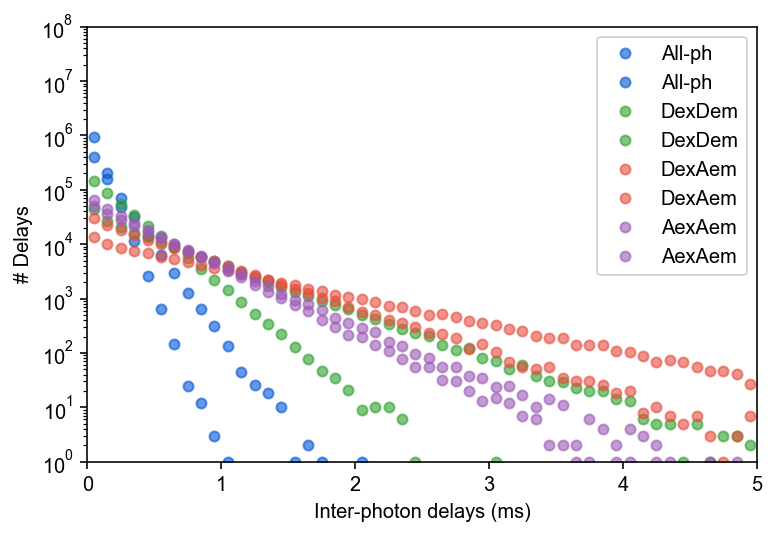

In [25]:
hist_interphoton(d0, d1, i=0, binwidth=1e-4, tmax=None, bins=None, period=None,
                     yscale='log', xscale='linear', xunit='ms', plot_style=None,
                     show_da=False, legend=True)
plt.xlim(50e-6, 5)
plt.ylim(1, 1e8)
plt.legend();

## Plot background rates

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will 

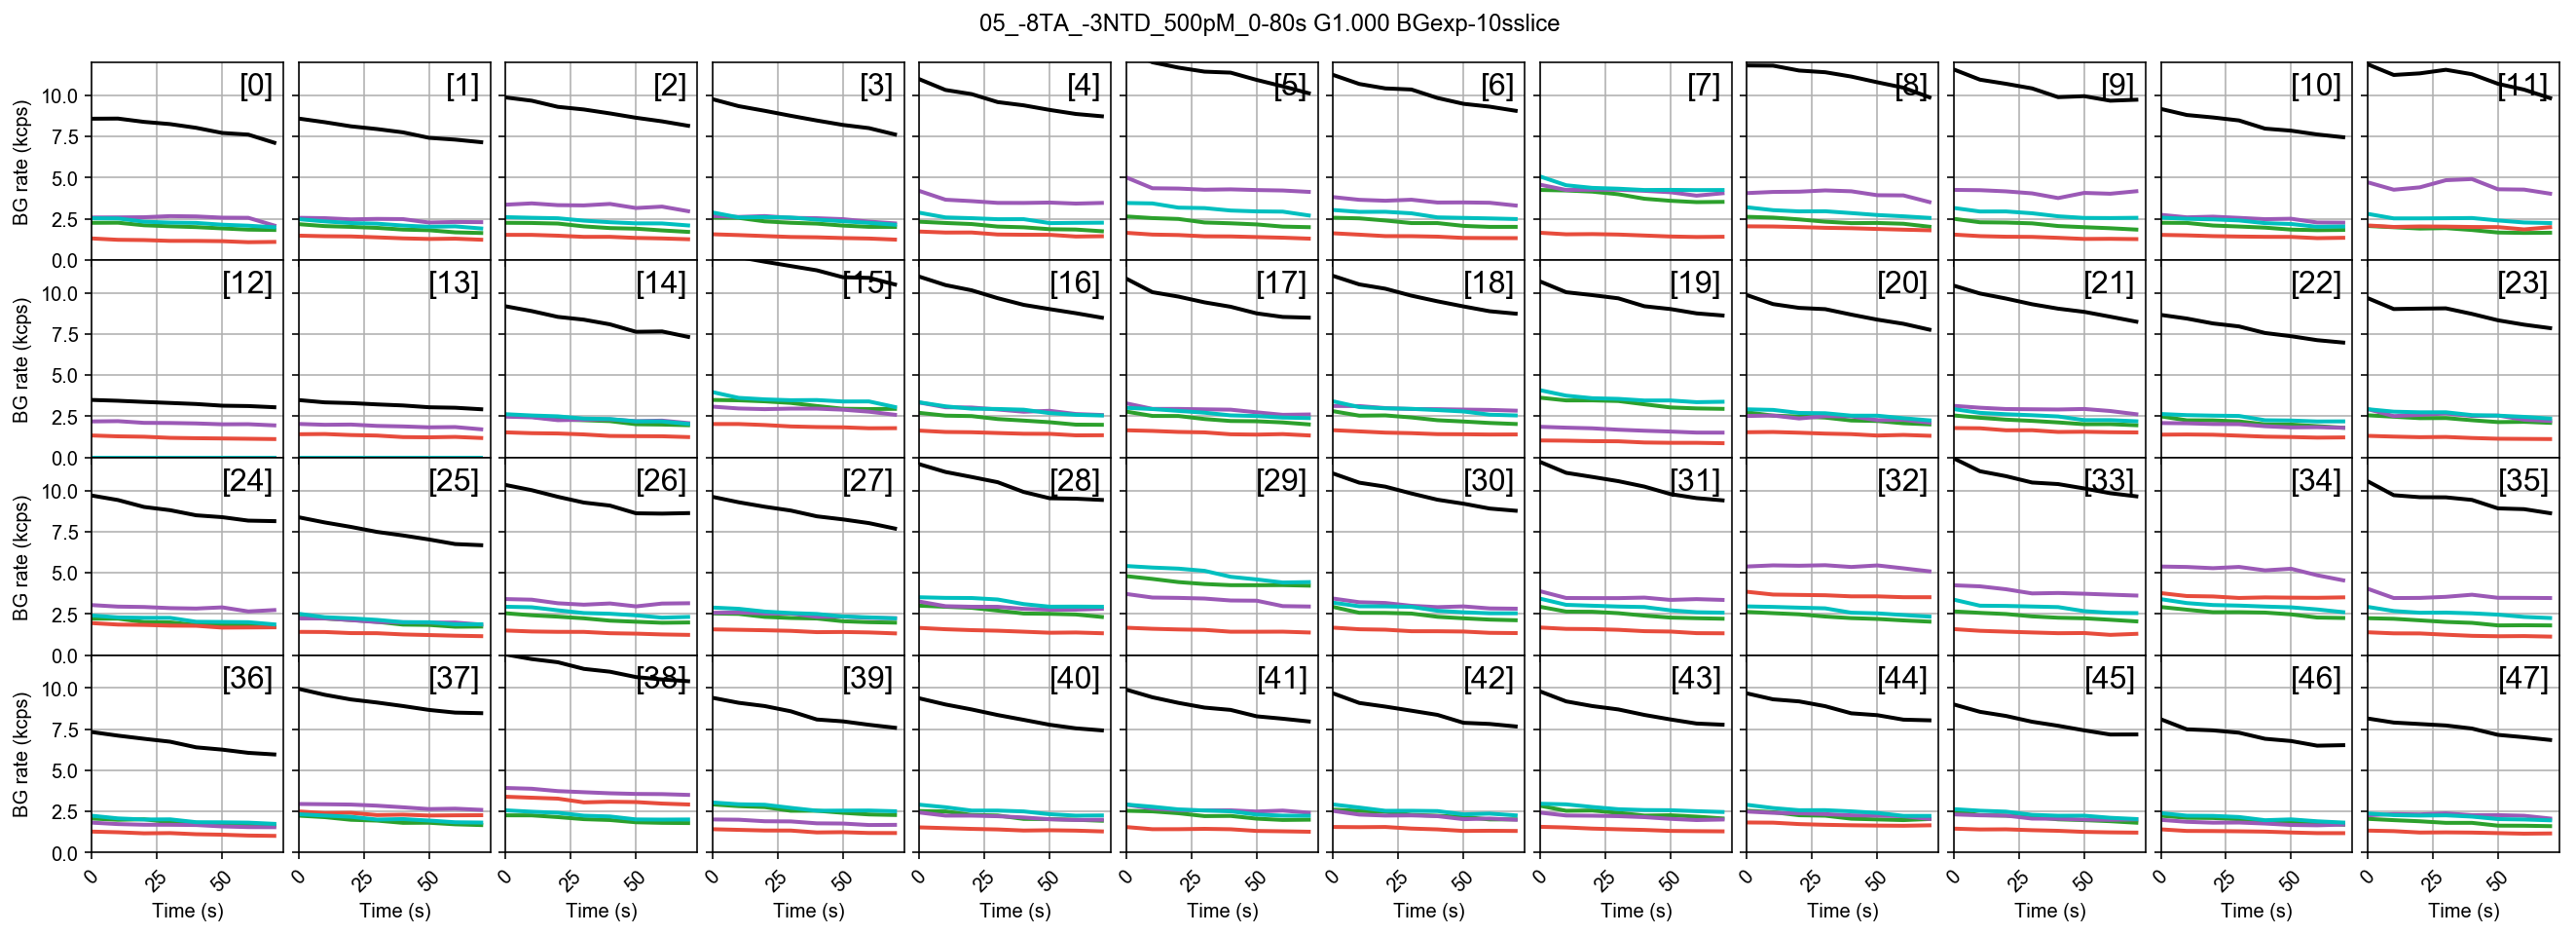

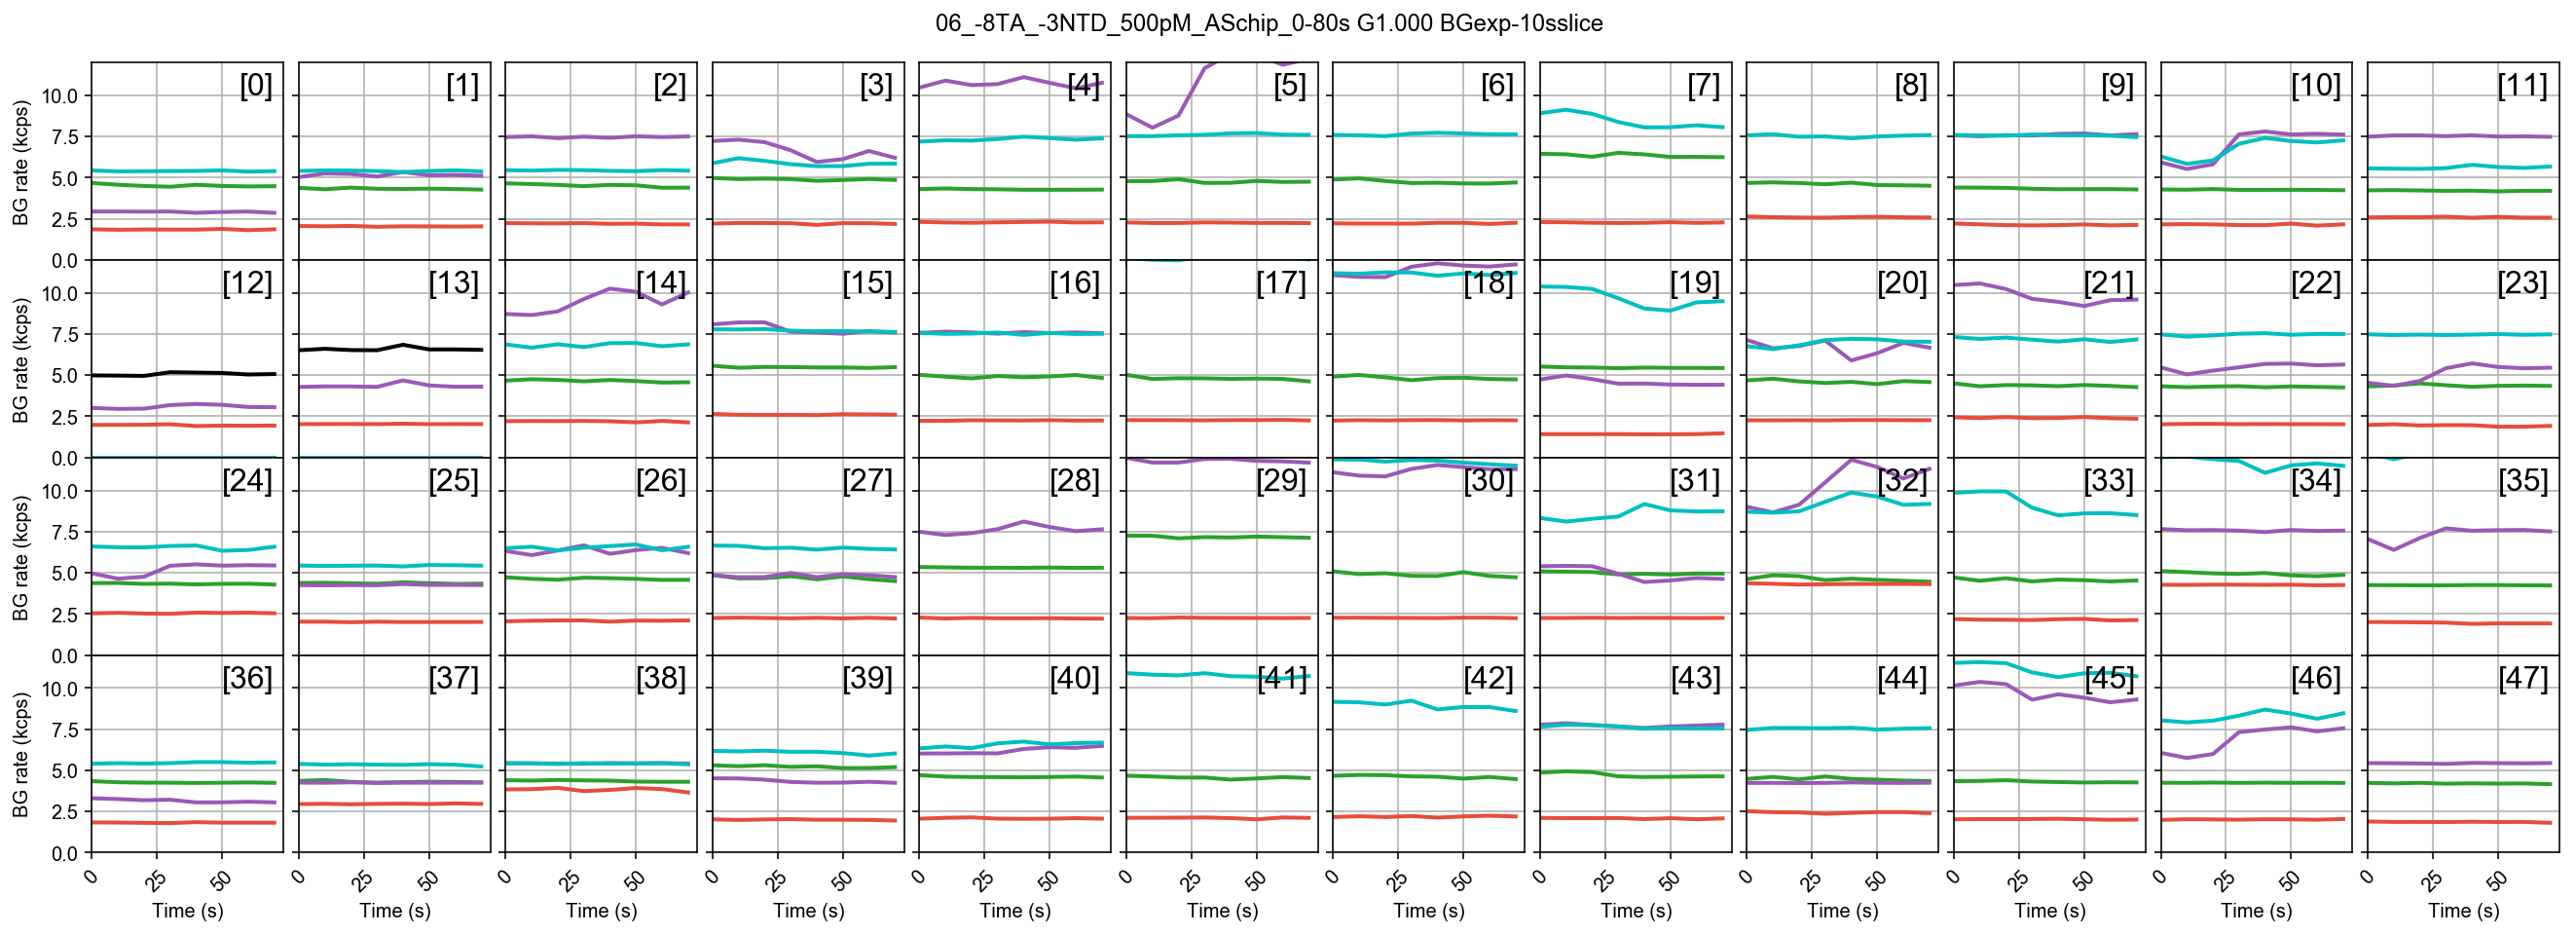

In [26]:
ax = dplot(d0, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45)
plt.xlim(0)
plt.ylim(0, 12)

ax = dplot(d1, timetrace_bg, show_da=True, hspace=0, wspace=0.08,
           plot_style=dict(marker=None), title='right top', 
           title_kws=dict(fontsize=16), xrotation=45)
plt.xlim(0)
plt.ylim(0, 12);

In [27]:
bg_AexDem_0 = d0.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem_0 = d0.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem_0 = d0.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem_0 = d0.bg_from(Ph_sel(Dex='Aem'))

bg_AexDem_1 = d1.bg_from(Ph_sel(Aex='Dem'))
bg_AexAem_1 = d1.bg_from(Ph_sel(Aex='Aem'))
bg_DexDem_1 = d1.bg_from(Ph_sel(Dex='Dem'))
bg_DexAem_1 = d1.bg_from(Ph_sel(Dex='Aem'))

In [28]:
import matplotlib.patches as mpatches

In [29]:
green_patch = mpatches.Patch(color=green, label='no flow')
red_patch = mpatches.Patch(color=red, label='no flow')
blue_patch = mpatches.Patch(color=blue, label='flow rate = 10μL/hr')
purple_patch = mpatches.Patch(color=purple, label='flow rate = 10μL/hr')

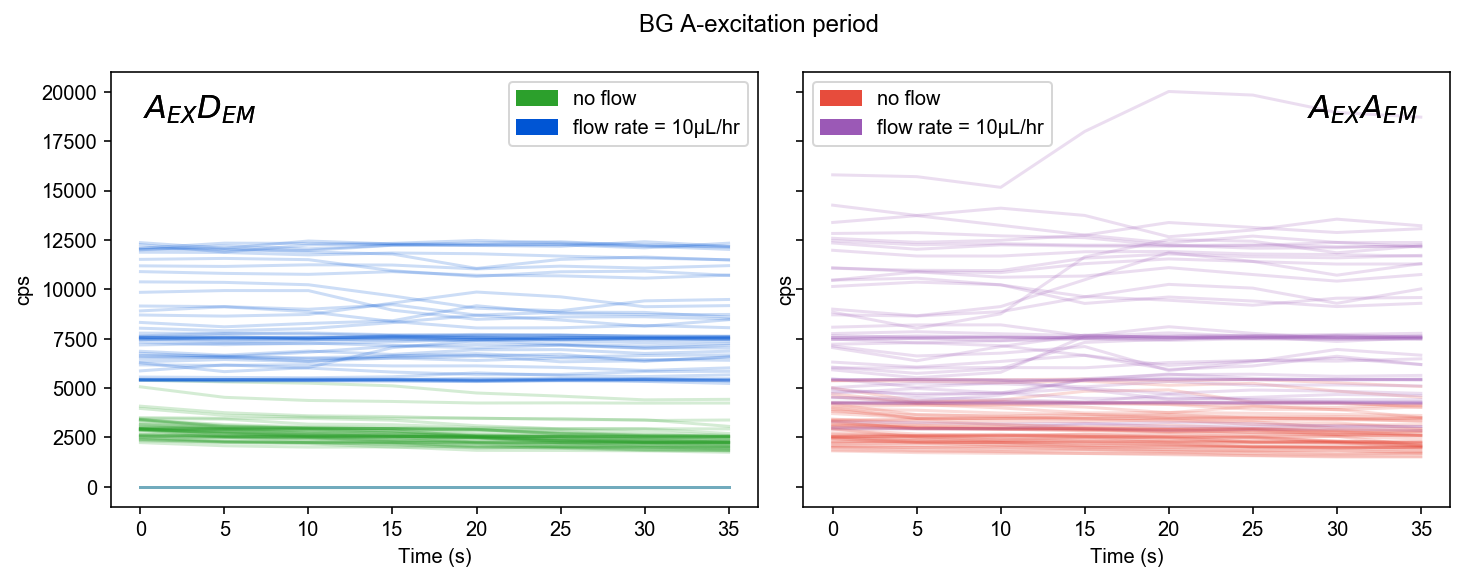

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG A-excitation period")
t0 = np.arange(len(bg_AexDem_0[0])) * 5
t1 = np.arange(len(bg_AexDem_1[0])) * 5
ax[0].plot(t0, np.array(bg_AexDem_0).T, color=green, alpha=0.2)
ax[1].plot(t0, np.array(bg_AexAem_0).T, color=red, alpha=0.2)
ax[0].plot(t1, np.array(bg_AexDem_1).T, color=blue, alpha=0.2)
ax[1].plot(t1, np.array(bg_AexAem_1).T, color=purple, alpha=0.2)
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, '$A_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$A_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].legend(handles=[green_patch, blue_patch], loc='upper right')
ax[1].legend(handles=[red_patch, purple_patch], loc='upper left');

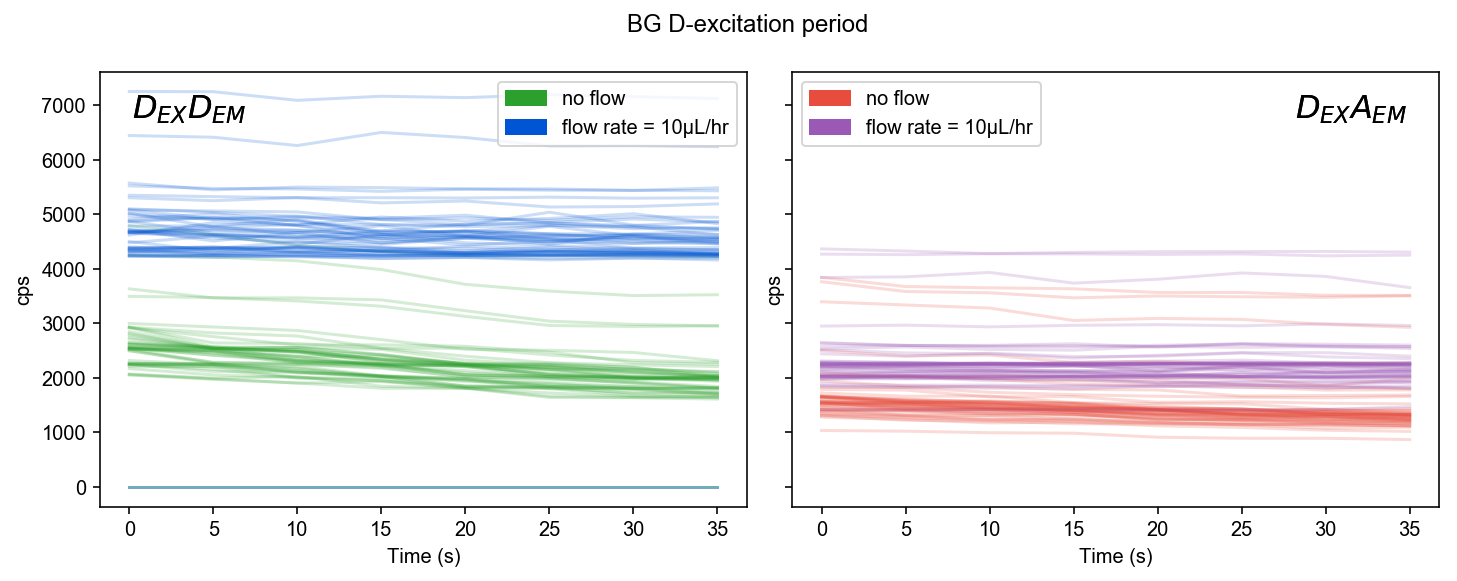

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle("BG D-excitation period")
t0 = np.arange(len(bg_DexDem_0[0])) * 5
t1 = np.arange(len(bg_DexDem_1[0])) * 5
ax[0].plot(t0, np.array(bg_DexDem_0).T, color=green, alpha=0.2)
ax[1].plot(t0, np.array(bg_DexAem_0).T, color=red, alpha=0.2)
ax[0].plot(t1, np.array(bg_DexDem_1).T, color=blue, alpha=0.2)
ax[1].plot(t1, np.array(bg_DexAem_1).T, color=purple, alpha=0.2)
plt.setp(ax, xlabel='Time (s)', ylabel='cps')
plt.subplots_adjust(wspace=0.07)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].text(0.05, 0.95, '$D_{EX}D_{EM}$', va='top', fontsize=16, transform=ax[0].transAxes)
ax[1].text(0.95, 0.95, '$D_{EX}A_{EM}$', va='top', ha='right', fontsize=16, transform=ax[1].transAxes)
ax[0].legend(handles=[green_patch, blue_patch], loc='upper right')
ax[1].legend(handles=[red_patch, purple_patch], loc='upper left');

# Burst search

In [32]:
d0.burst_search(min_rate_cps=50e3, pax=True)
d1.burst_search(min_rate_cps=50e3, pax=True)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [33]:
size_th = 20
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='DAem'),
                    na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

In [34]:
bs_mean_0 = []
bs_mean_1 = []

for i in range(48):
    sizes_ch = d0.burst_sizes_pax_ich(i, **size_sel_kws) 
    tail = sizes_ch > size_th
    bs_mean_0.append(sizes_ch[tail].mean() - size_th)
    
for i in range(48):
    sizes_ch = d1.burst_sizes_pax_ich(i, **size_sel_kws) 
    tail = sizes_ch > size_th
    bs_mean_1.append(sizes_ch[tail].mean() - size_th)

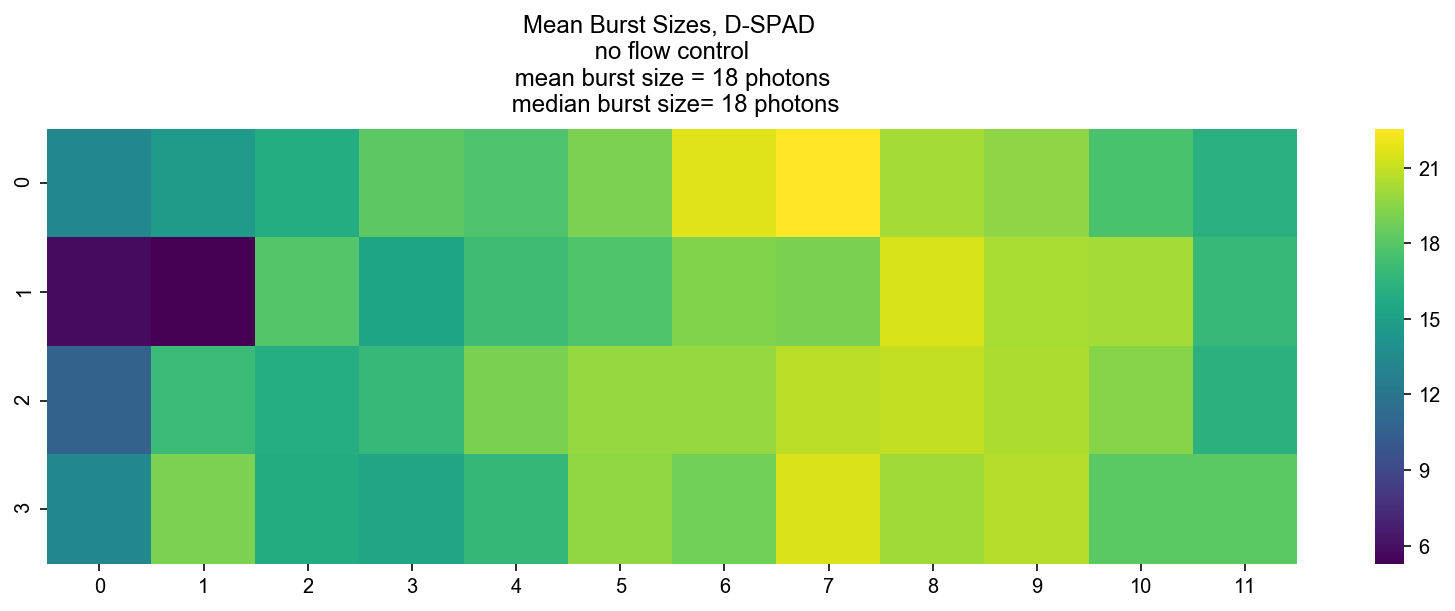

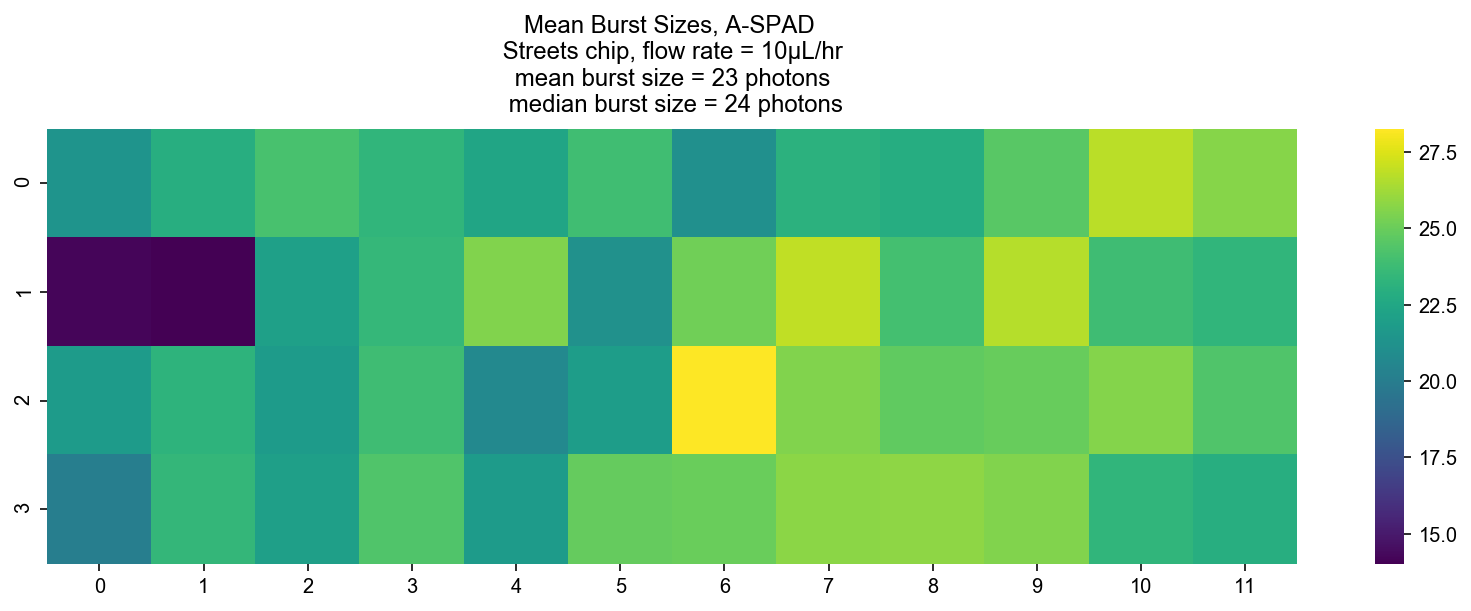

In [35]:
bs_median_0 = np.int(np.around(np.median(bs_mean_0)))
bs_median_1 = np.int(np.around(np.median(bs_mean_1)))
bs_mean_mean_0 = np.int(np.around(np.mean(bs_mean_0)))
bs_mean_mean_1 = np.int(np.around(np.mean(bs_mean_1)))


heatmap48(bs_mean_0, cmap='viridis', 
          title=f'Mean Burst Sizes, D-SPAD \n no flow control \n mean burst size = {bs_mean_mean_0} photons \n median burst size= {bs_median_0} photons')
#savefig('heatmap_burst_sizes')

heatmap48(bs_mean_1, cmap='viridis', 
          title=f"Mean Burst Sizes, A-SPAD \n Streets chip, flow rate = 10μL/hr \n mean burst size = {bs_mean_mean_1} photons \n median burst size = {bs_median_1} photons")
#savefig(f'heatmap_burst_sizes_{mlabel[1]}')

In [36]:
bw_mean_0 = []
bw_mean_1 = []
width_th = 0.4

for i in range(48):
    widths_ch = d0.mburst[i].width * d0.clk_p * 1e3
    tail = widths_ch > width_th
    bw_mean_0.append(widths_ch[tail].mean() - width_th)
    
for i in range(48):
    widths_ch = d1.mburst[i].width * d1.clk_p * 1e3
    tail = widths_ch > width_th
    bw_mean_1.append(widths_ch[tail].mean() - width_th)

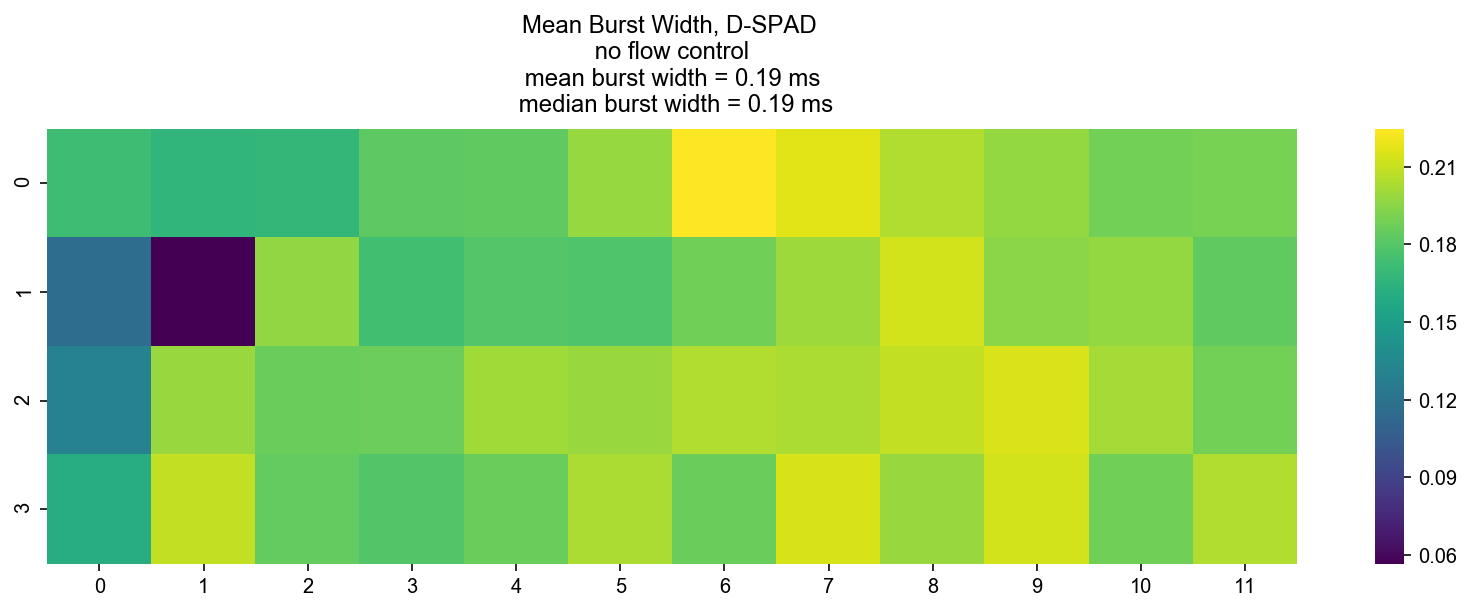

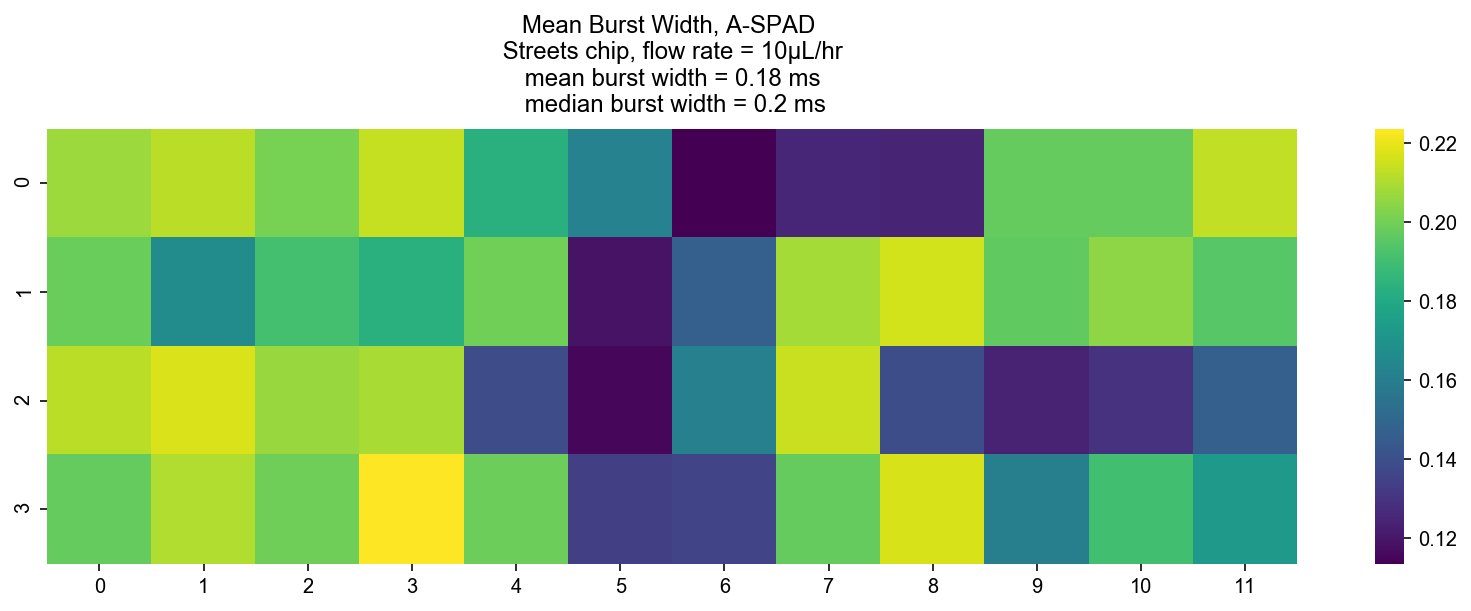

In [37]:
bw_median_0 = np.around(np.median(bw_mean_0), 2)
bw_median_1 = np.around(np.median(bw_mean_1), 2)
bw_mean_mean_0 = np.around(np.mean(bw_mean_0), 2)
bw_mean_mean_1 = np.around(np.mean(bw_mean_1), 2)

heatmap48(bw_mean_0, cmap='viridis',
          title=f"Mean Burst Width, D-SPAD \n no flow control \n mean burst width = {bw_mean_mean_0} ms \n median burst width = {bw_median_0} ms")
#savefig('heatmap_burst_widths')

heatmap48(bw_mean_1, cmap='viridis',
          title=f"Mean Burst Width, A-SPAD \n Streets chip, flow rate = 10μL/hr \n mean burst width = {bw_mean_mean_1} ms \n median burst width = {bw_median_1} ms")
#savefig('heatmap_burst_widths')

# Burst selection

In [38]:
size_th = 80
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
ds0 = d0.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds0.nd, ds0.na, ds0.naa)]
ds0.add(Su=Su)
Su2 = [(nd + nda + na)/(nd + nda + na + naa) 
       for nd, na, nda, naa in zip(ds0.nd, ds0.na, ds0.nda, ds0.naa)]
ds0.add(Su2=Su2)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

In [39]:
size_th = 80
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
ds1 = d1.select_bursts(select_bursts.size, th1=size_th, **size_sel_kws)

Su = [(nd + na)/(nd + na + naa) for nd, na, naa in zip(ds1.nd, ds1.na, ds1.naa)]
ds1.add(Su=Su)
Su2 = [(nd + nda + na)/(nd + nda + na + naa) 
       for nd, na, nda, naa in zip(ds1.nd, ds1.na, ds1.nda, ds1.naa)]
ds1.add(Su2=Su2)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

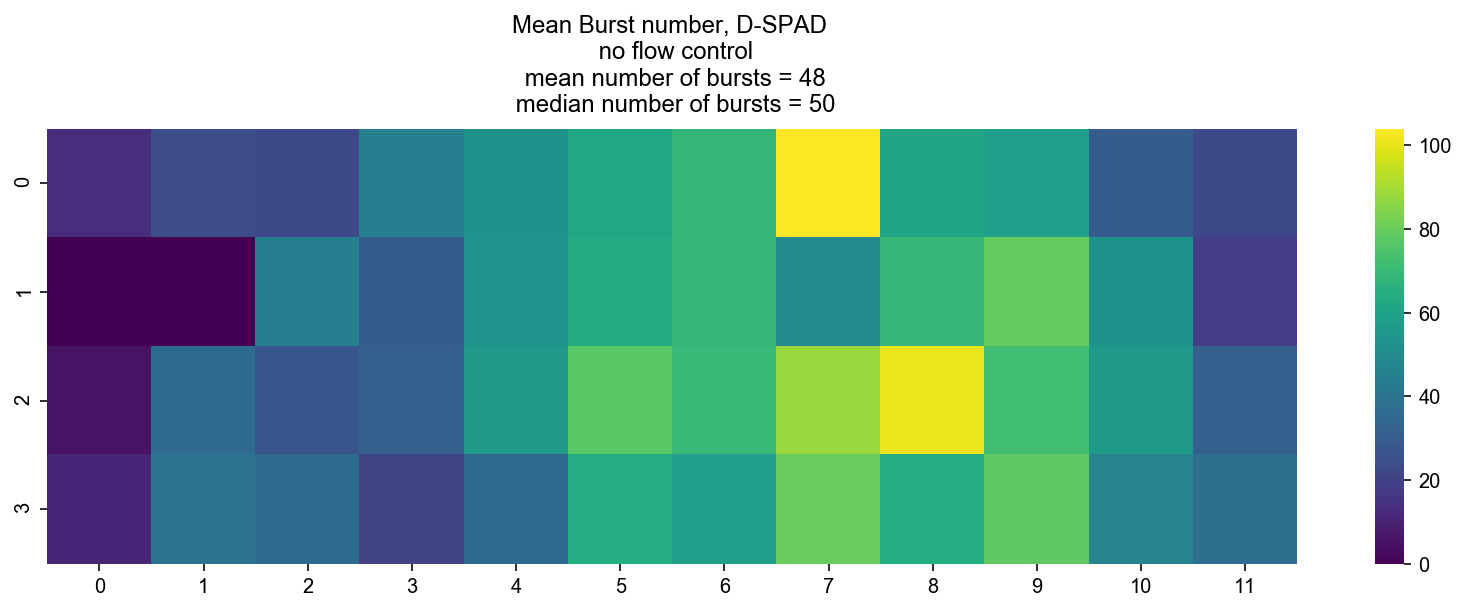

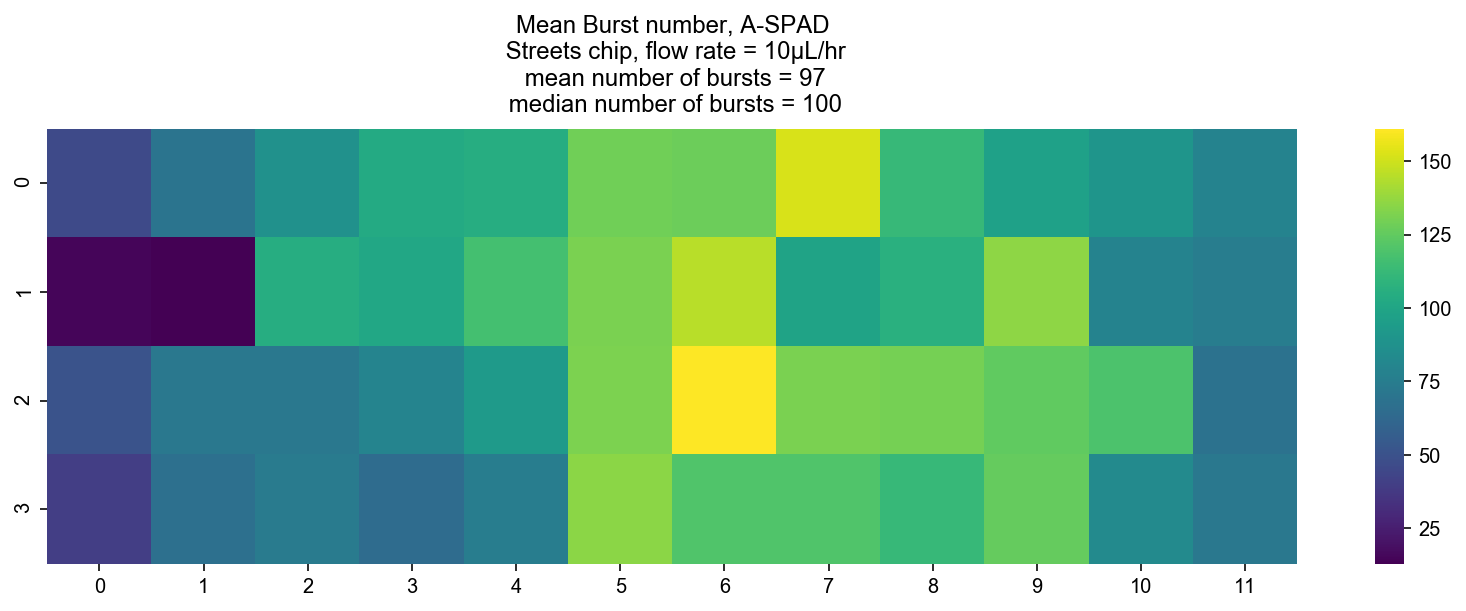

In [40]:
num_burst_median_0 = np.int(np.around(np.median(ds0.num_bursts)))
num_burst_median_1 = np.int(np.around(np.median(ds1.num_bursts)))
num_burst_mean_mean_0 = np.int(np.around(np.mean(ds0.num_bursts)))
num_burst_mean_mean_1 = np.int(np.around(np.mean(ds1.num_bursts)))

heatmap48(ds0.num_bursts, cmap='viridis',
          title='Mean Burst number, D-SPAD \n no flow control' 
          f'\n mean number of bursts = {num_burst_mean_mean_0}' 
          f'\n median number of bursts = {num_burst_median_0}')

heatmap48(ds1.num_bursts, cmap='viridis',
          title='Mean Burst number, A-SPAD' 
          '\n Streets chip, flow rate = 10μL/hr' 
          f'\n mean number of bursts = {num_burst_mean_mean_1}' 
          f'\n median number of bursts = {num_burst_median_1}')

# Collapse

Pooling data from all 48 spots

In [41]:
naa_sel_kws = dict(ph_sel=Ph_sel(Aex='Aem'), gamma=1,
                   na_comp=False, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**naa_sel_kws))

<IPython.core.display.Math object>

In [42]:
size_sel_kws = dict(ph_sel=Ph_sel(Dex='DAem', Aex='Dem'), gamma=0.5,
                    na_comp=True, naa_comp=False, naa_aexonly=False)
Math(d0._burst_sizes_pax_formula(**size_sel_kws))

<IPython.core.display.Math object>

Two size selections for isolation of the FRET population using ACBS.

In [43]:
ds0_th1 = ds0.select_bursts(select_bursts.size, th1=10, **naa_sel_kws)
ds0_th2 = ds0_th1.select_bursts(select_bursts.size, th1=20, **size_sel_kws)
dcs0_th = ds0_th2.collapse(update_gamma=False)

ds1_th1 = ds1.select_bursts(select_bursts.size, th1=10, **naa_sel_kws)
ds1_th2 = ds1_th1.select_bursts(select_bursts.size, th1=20, **size_sel_kws)
dcs1_th = ds1_th2.collapse(update_gamma=False)

# Save results to CSV

In [48]:
Path('results/').mkdir(exist_ok=True)

In [49]:
max_rate0 = d0.calc_max_rate(m=10, ph_sel=Ph_sel('all'))
max_rate1 = d1.calc_max_rate(m=10, ph_sel=Ph_sel('all'))
max_rate0

## Save 48-spot burst results

In [50]:
fname_bsearch_data0 = f'results/{f0}_burst_data'
fname_bsearch_data1 = f'results/{f1}_burst_data'
fname_bsearch_data0, fname_bsearch_data1

('results/05_-8TA_-3NTD_500pM_0-80s_burst_data',
 'results/06_-8TA_-3NTD_500pM_ASchip_0-80s_burst_data')

In [51]:
bsearch_data0 = bext.burst_data(d0, include_bg=False)
bsearch_data1 = bext.burst_data(d1, include_bg=False)

In [52]:
bsearch_data0.to_csv(fname_bsearch_data0 + '.csv')
bsearch_data1.to_csv(fname_bsearch_data1 + '.csv')

In [53]:
pd.read_csv(fname_bsearch_data0 + '.csv', index_col=0).head()

size_raw   t_start    t_stop  width_ms         E         S         nd  \
0        10  0.111762  0.111955  0.192625 -0.109697  0.378698   0.566183   
1        33  0.220837  0.221162  0.325062  0.163064  1.098282  15.267917   
2        13  0.231640  0.231863  0.222663 -0.051113  1.052553   9.498535   
3        13  0.231704  0.231950  0.246125 -0.069871  0.731326   7.445694   
4        11  0.235145  0.235333  0.187812  0.365185  1.052354   3.577022   

         na         nt        nda       naa       max_rate       nar  spot  
0 -0.251053   8.331979   4.513142  3.503707   32956.463262 -0.251053     0  
1  2.576337  30.185147  11.178408  1.162485  174177.702928  2.576337     0  
2 -0.290202  11.071872   2.437223 -0.573684   58489.854491 -0.290202     0  
3 -0.320781  10.868700   2.377922  1.365865   45575.087493 -0.320781     0  
4  1.755219   9.373653   2.525306  1.516106   39125.668436  1.755219     0

In [54]:
pd.read_csv(fname_bsearch_data1 + '.csv', index_col=0).head()

/Users/maya/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


size_raw   t_start    t_stop  width_ms         E         S         nd  \
0        13  0.107419  0.107582  0.162663  0.129792  1.033822   5.239882   
1        21  0.107743  0.108094  0.351037  0.309973  0.924282   4.359610   
2        10  0.107972  0.108166  0.194075  0.394203  1.410277   2.093092   
3        51  0.108023  0.108628  0.605100  0.126022  1.190686  22.172382   
4        10  0.110811  0.110991  0.180475  0.177109  1.054850   1.156645   

         na         nt        nda       naa       max_rate       nar  spot  
0  0.697730  10.575663   4.116193  0.521858   52532.416089  0.697730     0  
1  2.347679  15.768104   6.092681  2.968135   52688.558840  2.347679     0  
2  1.639357   7.107488   2.945517  0.429522   26434.775756  1.639357     0  
3  2.875563  41.981533  17.712263 -0.778675  213377.591246  2.875563     0  
4  0.664629   7.310184   5.019411  0.469499   29541.067555  0.664629     0